#  Project Name: Time Series Analysis and Modeling

#### Build time series model based on historical housing price from Zillow and find the top 5 best zip codes to invest in

Name: Bonnie Ma<br/>

https://github.com/bonniema

# Overview
<br>[Background and KPI](#001)
<br>[Step1: Load Data & Import Libraries](#002)
<br>[Step2: Data Processing](#003)
<br>[Step3: Data Exploration and Visualization](#004)
<br>[Step4: Initial ARIMA Models on Sample Zip Codes](#005)
<br>[Step5: Run SARIMA models on all Zipcodes](#006)
<br>[Step 6: Interpret the Results](#007)

# Background
<a id='001'></a>

This project assumes to be an investment firm based in New York City to provide detailed analysis and insights to investors who are interested in real estate for financial growth. Our target clients are mid-income families or individuals with initial budget under 500K and are looking to buy in 2020. 

The areas we will be focusing on is Manhattan and Brooklyn zipcodes with average house price under 3 Million in 2016-2018. 

#### Project KPI: 5 Yr ROI ((House Price of Year 5 - Buy Price) / Buy Price)

## Step 1: Load the Data/Import Libraries
<a id='002'></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

import itertools
import pandas as pd
import numpy as np

#for modeling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoLarsCV

#for visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
import time

In [2]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
ny=df[(df['City']=='New York')]

In [4]:
area = pd.read_csv('manhattan_brooklyn_zip.csv')
area.head()

,RegionName,District
0,10001,Manhattan
1,10002,Manhattan
2,10003,Manhattan
3,10004,Manhattan
4,10005,Manhattan


In [5]:
ny1 = pd.merge(ny, area, how='left', on='RegionName')

In [6]:
ny2 = ny1[ny1['District'].notnull()]
ny2.groupby('District').count()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
District,,,,,,,,,,,,,,,,,,,,,
Brooklyn,29,29,29,29,29,29,29,25,25,25,...,29,29,29,29,29,29,29,29,29,29
Manhattan,4,4,4,4,4,4,4,1,1,1,...,4,4,4,4,4,4,4,4,4,4


Only 4 zipcodes in Manhattan are present in the database. We will focus on Brooklyn then. 

In [7]:
ny3 = ny2[ny2['District']=='Brooklyn']
ny3.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,District
1,62037,11226,New York,NY,New York,Kings,11,162000.0,162300.0,162600.0,...,851000,853900,870000,885100,887800,890500,901700,930700,963200,Brooklyn
3,62045,11235,New York,NY,New York,Kings,14,190500.0,191000.0,191500.0,...,777300,788800,793900,796000,799700,806600,810600,813400,816200,Brooklyn
9,62040,11230,New York,NY,New York,Kings,48,230100.0,230800.0,231500.0,...,1082700,1082800,1084900,1091200,1102400,1120200,1141600,1170000,1195400,Brooklyn
10,62020,11209,New York,NY,New York,Kings,50,255700.0,256600.0,257300.0,...,1013400,1019500,1024400,1024900,1018900,1023500,1029200,1023000,1015800,Brooklyn
11,62023,11212,New York,NY,New York,Kings,54,125000.0,125000.0,125000.0,...,387000,394600,401500,407900,414900,422300,426300,427100,428400,Brooklyn


In [8]:
ny4 = ny3.drop(['RegionID','City','State','Metro','CountyName','SizeRank','District'], axis ='columns')

In [9]:
ny4.head()

,RegionName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1,11226,162000.0,162300.0,162600.0,163000.0,163400.0,164000.0,164700.0,165700.0,166800.0,...,860200,851000,853900,870000,885100,887800,890500,901700,930700,963200
3,11235,190500.0,191000.0,191500.0,192000.0,192500.0,193000.0,193600.0,194300.0,195300.0,...,767300,777300,788800,793900,796000,799700,806600,810600,813400,816200
9,11230,230100.0,230800.0,231500.0,232100.0,232800.0,233600.0,234700.0,235900.0,237500.0,...,1079200,1082700,1082800,1084900,1091200,1102400,1120200,1141600,1170000,1195400
10,11209,255700.0,256600.0,257300.0,258100.0,258900.0,259800.0,260900.0,262000.0,263600.0,...,1005000,1013400,1019500,1024400,1024900,1018900,1023500,1029200,1023000,1015800
11,11212,125000.0,125000.0,125000.0,125000.0,125100.0,125100.0,125000.0,124800.0,124600.0,...,380000,387000,394600,401500,407900,414900,422300,426300,427100,428400


## Step 2: Reshape from Wide to Long Format & Data Processing
<a id='003'></a>

In [10]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName'], var_name='Month', value_name = 'MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format = '%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [11]:
dfm = melt_data(ny4)

In [12]:
dfm.head()

,RegionName,Month,MeanValue
0,11226,1996-04-01,162000.0
1,11235,1996-04-01,190500.0
2,11230,1996-04-01,230100.0
3,11209,1996-04-01,255700.0
4,11212,1996-04-01,125000.0


In [13]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7313 entries, 0 to 7684
Data columns (total 3 columns):
RegionName    7313 non-null int64
Month         7313 non-null datetime64[ns]
MeanValue     7313 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 228.5 KB


In [14]:
dfm.set_index('Month', inplace = True)

In [15]:
dfm.head(10)

,RegionName,MeanValue
Month,,
1996-04-01,11226,162000.0
1996-04-01,11235,190500.0
1996-04-01,11230,230100.0
1996-04-01,11209,255700.0
1996-04-01,11212,125000.0
1996-04-01,11214,191000.0
1996-04-01,11221,133700.0
1996-04-01,11229,183900.0
1996-04-01,11234,172300.0


## Step 3: EDA and Visualization
<a id='004'></a>

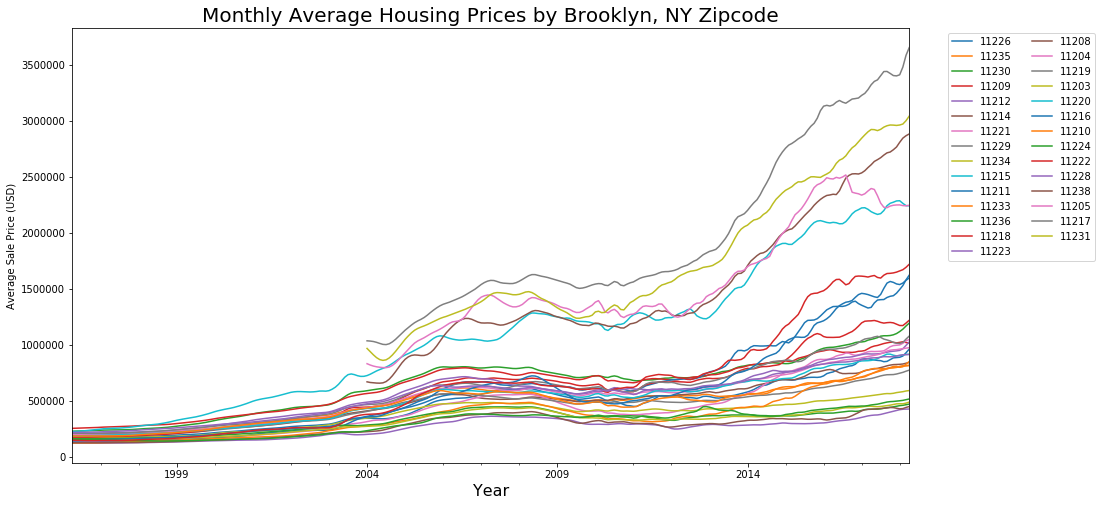

In [16]:
for zipcode in dfm.RegionName.unique():
    temp_df = dfm[dfm.RegionName == zipcode]
    temp_df['MeanValue'].plot(figsize = (15,8), label=zipcode)

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', ncol=2)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Average Sale Price (USD)")
plt.title('Monthly Average Housing Prices by Brooklyn, NY Zipcode', fontsize = 20);


### Observations of the data:
- 25 zip codes have data from 1996 to 2018, however, 4 zip codes do not
- There was a dip in 2008 and 2010, housing price became stable around 2011.

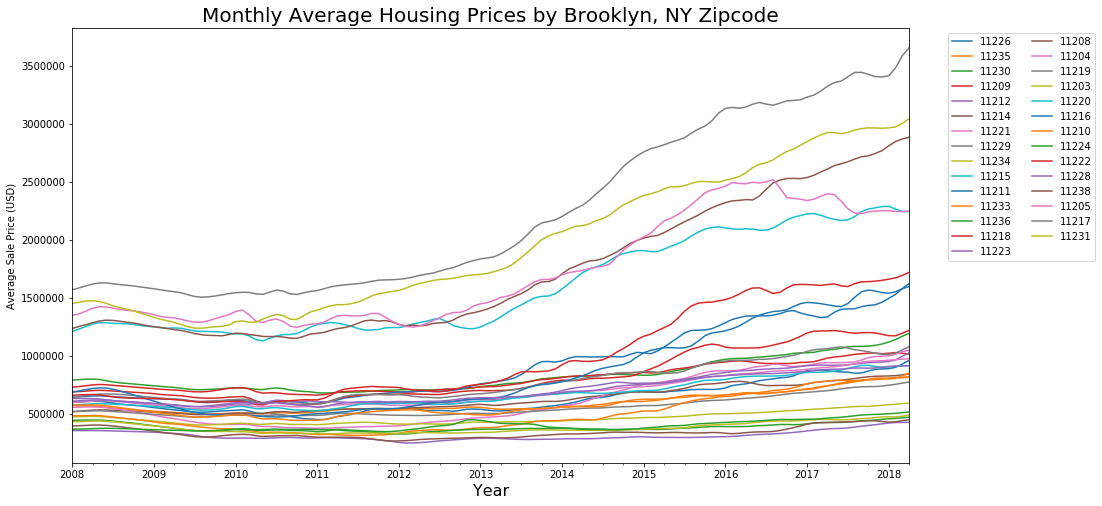

In [17]:
#A deeper look at 2008 above
for zipcode in dfm.RegionName.unique():
    temp_df = dfm[dfm.RegionName == zipcode]
    temp_df['2008':]['MeanValue'].plot(figsize = (15,8), label=zipcode)

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', ncol=2)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Average Sale Price (USD)")
plt.title('Monthly Average Housing Prices by Brooklyn, NY Zipcode', fontsize = 20);


To get more accurate prediction on 2020 and onwards data,  we decided to use data 2011-Present. 

### Seasonal Decomposition for 2011 and Above

In [18]:
df2011 = dfm['2011':]
month_avg = df2011.groupby('Month')['MeanValue'].mean()

In [19]:
month_avg.head()

Month
2011-01-01    633365.517241
2011-02-01    638334.482759
2011-03-01    647358.620690
2011-04-01    655465.517241
2011-05-01    659955.172414
Name: MeanValue, dtype: float64

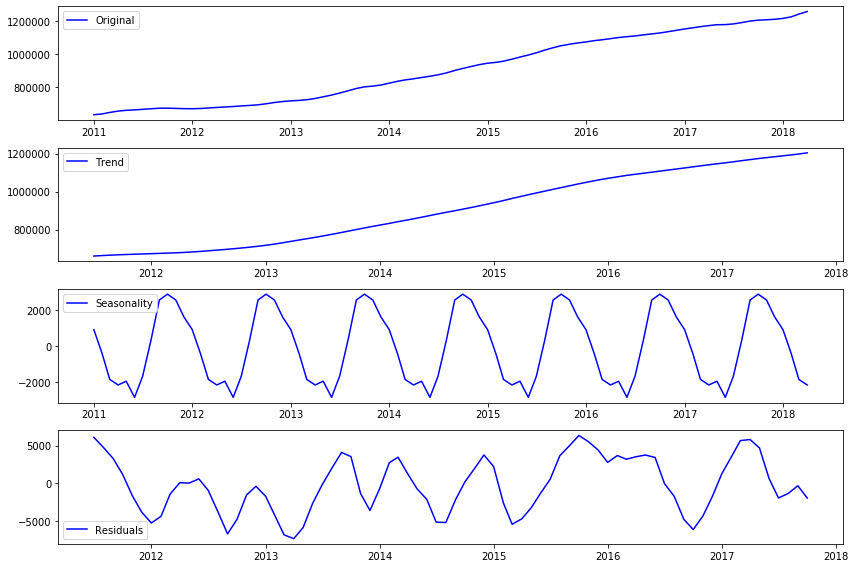

In [20]:
decomposition = sm.tsa.seasonal_decompose(month_avg, model='additive')

#Gather the trend, seasonality, and residualsbb
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(month_avg, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

An upward trend is present with yearly sesasonal changes. Let's check stationarity of residuals.

In [21]:
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

In [22]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

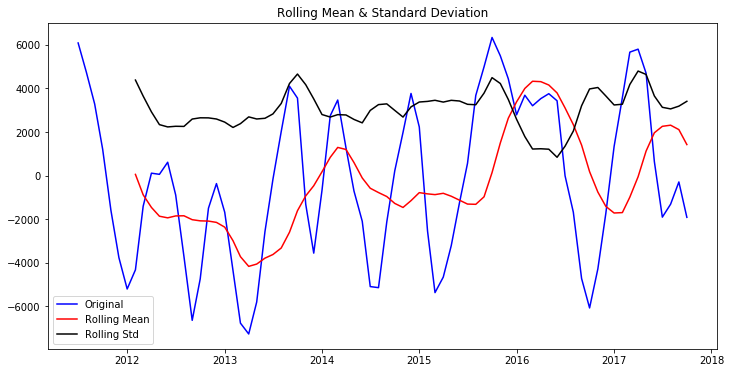

Results of Dickey-Fuller Test: 

Test Statistic                 -2.527008
p-value                         0.109040
#Lags Used                      6.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64


In [23]:
stationarity_check(ts_log_decompose)

The p-value is larger than 0.05. We can reject the null which means the residuals are not stationary. 

### Autocorrelation

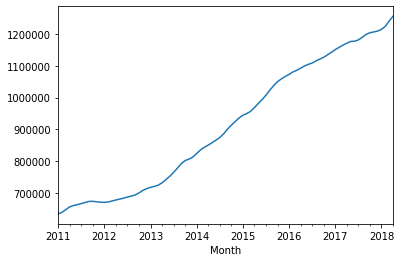

In [24]:
month_avg.plot()

#### The monthly average house price of Brooklyn increased year over year. No obvious autocorrelation and partial autocorrelation is present. 

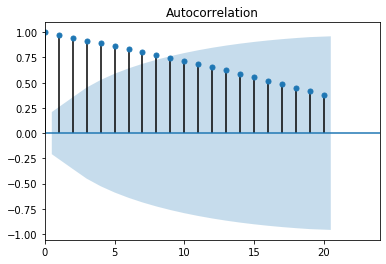

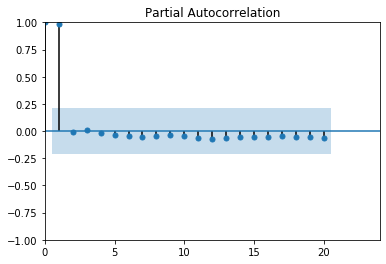

In [25]:
plot_acf(month_avg); plt.xlim(0,24); plt.show()
plot_pacf(month_avg); plt.xlim(0,24); plt.ylim(-1,1);plt.show()

#### If take lag = 3 difference. Autocorrlation appears.

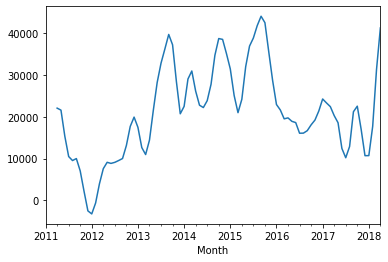

In [26]:
month_avg.diff(periods=3).plot()

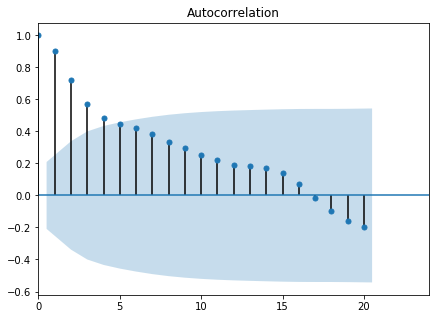

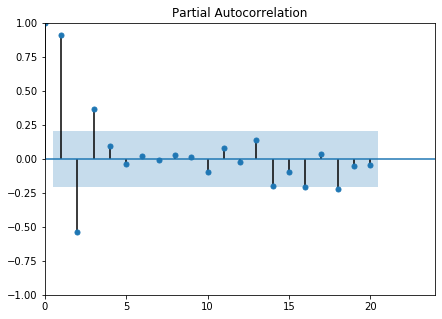

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize']=7,5
plot_acf(month_avg.diff(periods=3).bfill()); plt.xlim(0,24); plt.show()
plot_pacf(month_avg.diff(periods=3).bfill()); plt.xlim(0,24); plt.ylim(-1,1);plt.show()

## Step 4: Initial SARIMA Models on Sample Zip Codes
<a id='005'></a>

In [28]:
dfm.RegionName.unique()

array([11226, 11235, 11230, 11209, 11212, 11214, 11221, 11229, 11234,
       11215, 11211, 11233, 11236, 11218, 11223, 11208, 11204, 11219,
       11203, 11220, 11216, 11210, 11224, 11222, 11228, 11238, 11205,
       11217, 11231])

In [29]:
#Select 3 zipcodes
zip_dfs = []
zip_list = np.array([11231,11205,11217])
for x in zip_list:
    zip_dfs.append(pd.DataFrame(dfm[dfm['RegionName']==x][['MeanValue']].copy()))


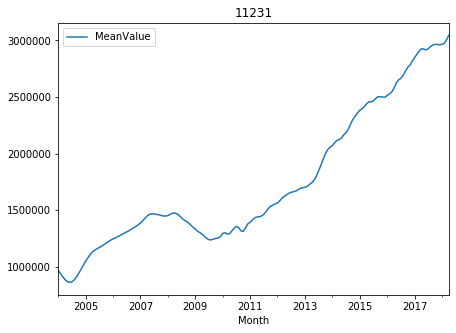

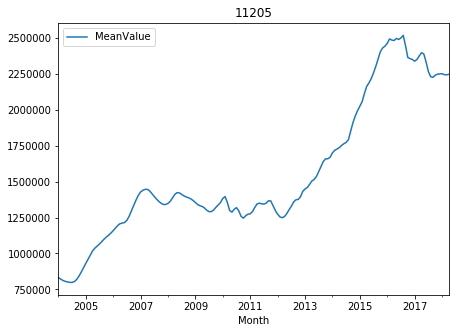

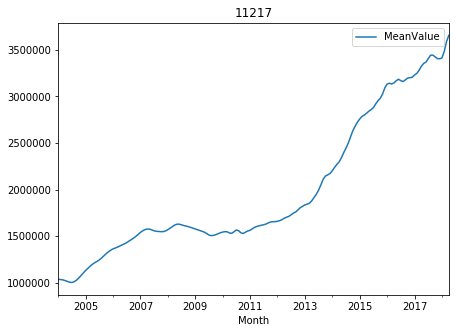

In [30]:
for df, name in zip(zip_dfs, zip_list):
    df.plot()
    plt.title(name)
    plt.show()

In [31]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p,d,q))
# Generate all different combinations of seasonal p, d and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [32]:
print(pdqs)

[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [33]:
#Run SARIMA
ans = []

for df, name in zip(zip_dfs, zip_list):
    for para1 in pdq:
        for para2 in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order = para1,
                                                seasonal_order = para2,
                                                enforce_stationarity = False,
                                                enforce_invertibility = False)
                output = mod.fit()
                ans.append([name, para1, para2, output.aic])
                print('Result for {}'.format(name) + ' ARIMA {} x {}12 : AIC Calculated = {}'.format(para1, para2, output.aic))
            except:
                continue

Result for 11231 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5423.9708093629815


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4953.349720389924
Result for 11231 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4343.500124754707
Result for 11231 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3964.1793651985413
Result for 11231 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4224.726704777125


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4167.708544125224
Result for 11231 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3911.0932416918577


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3886.920566948402
Result for 11231 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5271.202299206424


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4873.687914990351
Result for 11231 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4438.507909420658


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3870.2653531522665
Result for 11231 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4921.71448506579


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4862.131976482922
Result for 11231 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3913.1470637304637


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4100.647858630105
Result for 11231 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3861.602234144147
Result for 11231 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3561.8269325149613
Result for 11231 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3598.6345347651754
Result for 11231 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3298.557377541805
Result for 11231 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3571.7301436694715


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS wil

Result for 11231 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3545.787247456936
Result for 11231 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3305.4054377810953
Result for 11231 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3286.5434875354804


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3691.4084416182977
Result for 11231 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3419.401081504642
Result for 11231 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3565.5281510856203


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3177.368616245621
Result for 11231 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3469.951289651656


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3421.400120323694
Result for 11231 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3242.6949995762034


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3199.745929799878
Result for 11231 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3799.3984448890315
Result for 11231 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 12287.28226022642
Result for 11231 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3629.473108489582


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

Result for 11231 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3621.97726705579
Result for 11231 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3515.989060020136
Result for 11231 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 11529.240821037252
Result for 11231 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3315.112790991445


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3317.0829204353386
Result for 11231 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3622.630047755558


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5866.726811229818
Result for 11231 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3660.8101526050386


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4937.2239632203145
Result for 11231 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3381.655873005023


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5728.81135958306
Result for 11231 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3257.3771665145396


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11231 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4926.4300499609835
Result for 11231 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3590.5809309655833
Result for 11231 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3341.35495527807
Result for 11231 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3456.7880346457705
Result for 11231 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3182.394734398967
Result for 11231 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3340.4593052338705
Result for 11231 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3342.4530701185677


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3152.2700026004172
Result for 11231 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3154.1497149255465


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3558.3971696526196
Result for 11231 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3278.7614824311777
Result for 11231 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3427.846312744631


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3134.173215835507
Result for 11231 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3299.4145561362075


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3279.6679674509587


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3142.859577473212


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3114.3225284358336
Result for 11205 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5379.953671313097
Result for 11205 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4910.002323711959
Result for 11205 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4347.903583088452


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3987.3432395020036
Result for 11205 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4340.589134433099


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4288.276807780529
Result for 11205 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3994.708754284097


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3969.6770257117523
Result for 11205 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5227.254918752762


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5160.454165203177
Result for 11205 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4434.76760961398


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3975.4563454760255
Result for 11205 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5291.41726003838


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5158.257151654316
Result for 11205 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3925.7149201519105


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3975.84183797437
Result for 11205 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3923.176889074811
Result for 11205 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3651.078233254305
Result for 11205 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3737.8241919908405
Result for 11205 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3436.7169588203014
Result for 11205 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3674.531159717189


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS wil

Result for 11205 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3652.663320310093
Result for 11205 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3453.1445175012186
Result for 11205 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3429.9872650883376
Result for 11205 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3739.7273971523887


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3478.48689964206
Result for 11205 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3651.656037366083


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3328.6556374970132
Result for 11205 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3521.961800834697


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3479.5688364252273


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3377.4131412999704


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3330.584056201553
Result for 11205 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3930.0629066955735
Result for 11205 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7230.066270143701
Result for 11205 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3762.733474314592


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

Result for 11205 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3490.5935128153233
Result for 11205 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3662.790930947036
Result for 11205 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6730.9086402831235
Result for 11205 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3456.6741236967073


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3457.7007449275716
Result for 11205 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3753.749225889447


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 6893.109164724077
Result for 11205 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3691.68629290497


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5058.677491148017
Result for 11205 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3515.1894627816177


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 6509.732512924641


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3371.044378632756


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4687.006427665325
Result for 11205 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3767.2994996841167
Result for 11205 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3501.8854657948664
Result for 11205 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3643.919054780419


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3347.4989981611607
Result for 11205 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3502.2621481257047
Result for 11205 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3503.8677836841125


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3324.1196088102033


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3325.018436325903
Result for 11205 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3722.847528438273
Result for 11205 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3428.3833868125666
Result for 11205 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3604.63717285738


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3287.5722778802387
Result for 11205 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3450.8221875264126


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3425.3164565489005


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3310.228721516971


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3275.2679593203184
Result for 11217 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5468.611984809286
Result for 11217 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 13150537.934345828
Result for 11217 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4393.223069560115


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4015.2348606256073
Result for 11217 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4259.022133249397


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4204.784415199153
Result for 11217 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3886.6568383415506


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3859.3667022809004
Result for 11217 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5315.382505911115


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11217 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 13479309.809747722
Result for 11217 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4495.701191604037
Result for 11217 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3916.285209073866
Result for 11217 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5390.625757336396


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5253.571322732195
Result for 11217 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4076.9523040167846


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3902.443071723728
Result for 11217 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3929.103554355881
Result for 11217 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3608.6946219502015
Result for 11217 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3590.5887765076595
Result for 11217 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3322.845347796179
Result for 11217 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3599.339821468984


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS wil

Result for 11217 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3578.6169053785634
Result for 11217 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3344.2857254936257


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3324.4358283659294
Result for 11217 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3738.5270438569173
Result for 11217 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3456.315911159319


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3549.7058250369064
Result for 11217 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3188.811138082423


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3521.6584015261806
Result for 11217 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3458.068309926308
Result for 11217 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3231.899396935674


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3190.5787695630884
Result for 11217 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3848.1695680533976
Result for 11217 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3561.6836219622264


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3615.293252947703


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3360.6060665303485
Result for 11217 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3569.947889966049
Result for 11217 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3563.531271871204


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3346.29360830353


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3348.7660447467088
Result for 11217 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3696.510873211612


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 6472.07485043216
Result for 11217 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3657.098402968776


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4960.5552589470035


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3429.885113168313


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3402.732467673196
Result for 11217 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3230.862177004464


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4466.107970993433
Result for 11217 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3665.5380395560987
Result for 11217 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3417.241285266539
Result for 11217 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3489.974396641739


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3226.2993768568986
Result for 11217 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3417.145406032986
Result for 11217 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3419.09624137462


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3215.9770411918034


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3217.6979915508377
Result for 11217 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3633.3519372264946


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3339.381061975127
Result for 11217 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3467.8766918322717


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3161.884562078586
Result for 11217 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3359.650223736454


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3339.898847141589


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3183.4993831799575


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3163.8163476690656


In [34]:
result = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])

In [35]:
best_para = result.loc[result.groupby("name")["AIC"].idxmin()]

In [36]:
best_para

,name,pdq,pdqs,AIC
127,11205,"(1, 1, 1)","(1, 1, 1, 12)",3275.267959
187,11217,"(1, 1, 1)","(0, 1, 1, 12)",3161.884562
63,11231,"(1, 1, 1)","(1, 1, 1, 12)",3114.322528


In [37]:
#Mean house price in Brooklyn is above $1 Million
dfm['2017':]['MeanValue'].mean()

1195787.9310344828

{'whiskers': [<matplotlib.lines.Line2D at 0x11c24c518>,
 'caps': [<matplotlib.lines.Line2D at 0x11c24c128>,
 'boxes': [<matplotlib.lines.Line2D at 0x11c24c4a8>],
 'medians': [<matplotlib.lines.Line2D at 0x1c20ca6ba8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c20ca6c18>],
 'means': []}

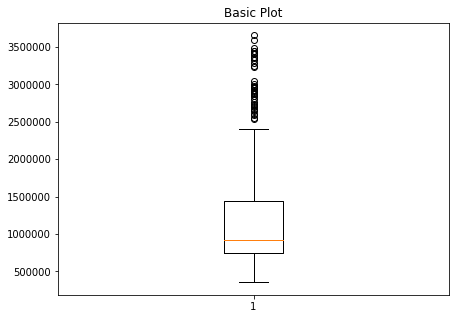

In [38]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(dfm['2017':]['MeanValue'])

### Plug the optimal parameter values into a new SARIMAX model to have a deeper look

In [39]:
# plug the optimal parameter values into a new SARIMAX model.

for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):
    
    ARIMA_MODEL = sm.tsa.SARIMAX(df, 
                           order = pdq,
                           seasonal_order = pdqs,
                           enforce_stationarity = False,
                           enforce_invertibility = False)
    
    output = ARIMA_MODEL.fit()
    print('SARIMA Model Result for {}'.format(name))
    print(output.summary().tables[1])
                           
                           
# Fit the model and print results

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMA Model Result for 11205
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7302      0.071     10.278      0.000       0.591       0.869
ma.L1          0.2318      0.033      7.053      0.000       0.167       0.296
ar.S.L12      -0.5738      0.086     -6.685      0.000      -0.742      -0.406
ma.S.L12      -0.0071      0.054     -0.131      0.895      -0.113       0.099
sigma2      1.344e+08   9.15e-11   1.47e+18      0.000    1.34e+08    1.34e+08


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMA Model Result for 11217
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4732      0.087      5.435      0.000       0.303       0.644
ma.L1          0.6258      0.064      9.720      0.000       0.500       0.752
ma.S.L12      -0.1747      0.043     -4.091      0.000      -0.258      -0.091
sigma2      4.017e+08    1.6e-11   2.52e+19      0.000    4.02e+08    4.02e+08


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMA Model Result for 11231
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4580      0.064      7.165      0.000       0.333       0.583
ma.L1          0.6972      0.047     14.867      0.000       0.605       0.789
ar.S.L12       0.0497      2.356      0.021      0.983      -4.568       4.668
ma.S.L12      -0.0633      2.350     -0.027      0.978      -4.669       4.542
sigma2        1.4e+08    9.9e-08   1.41e+15      0.000     1.4e+08     1.4e+08


### Make dynamic forecast using data up to 2017-06-01 and compare with real values post 2017-06-01

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


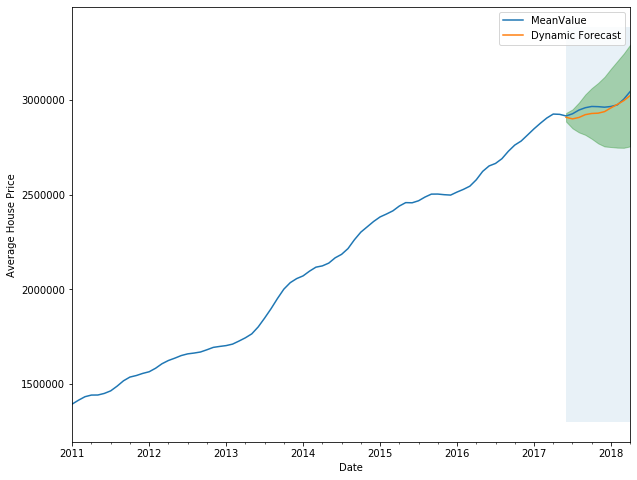

The Mean Squared Error of our forecasts is 25756.56


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


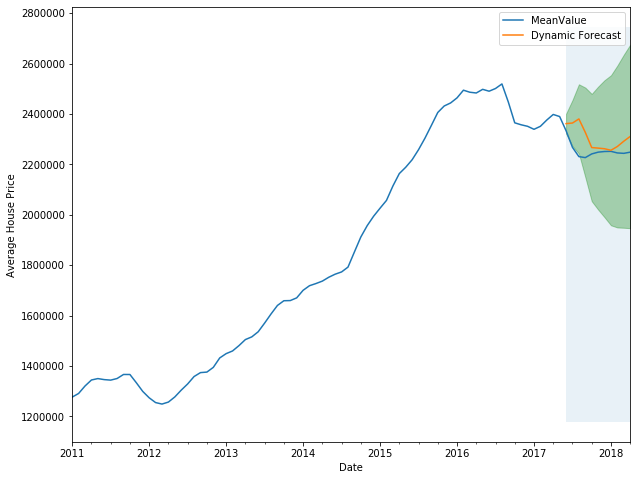

The Mean Squared Error of our forecasts is 67677.54


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


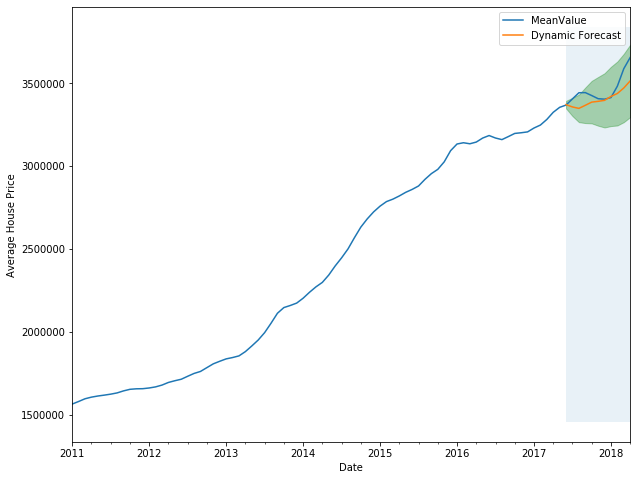

The Mean Squared Error of our forecasts is 70471.24


In [40]:
#Make Prediction post 2016 and compare with real values
summary_table = pd.DataFrame()
Zipcode = []
MSE_Value = []
models = []
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):

    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order = pdq,
                                 seasonal_order = pdqs,
                                 enforce_stationarity = False,
                                 enforce_invertibility = False)
                                
    output = ARIMA_MODEL.fit()
    models.append(output)
    
    #get dynamic predictions starting 2017-06-01
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-06-01'), dynamic = True, full_results = True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    zip_forecasted = pred_dynamic.predicted_mean
    zip_truth = df['2017-06-01':]['MeanValue']
    
    #Plot the dynamic forecast with confidence intervals as above
    ax = df['2011':].plot(label='observed', figsize=(10, 8))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-06-01'), zip_forecasted.index[-1], alpha=.1, zorder=-1)

    ax.set_xlabel('Date')
    ax.set_ylabel('Average House Price')

    plt.legend()
    plt.show()

    #print(type(zip_forecasted))
    #print(zip_truth)
    sqrt_mse = np.sqrt(((zip_forecasted - zip_truth)**2).mean())
    print('The Mean Squared Error of our forecasts is {}'.format(round(sqrt_mse, 2))) 
    
    Zipcode.append(name)
    MSE_Value.append(sqrt_mse)
    
summary_table['Zipcode'] = Zipcode
summary_table['Sqrt_MSE'] = MSE_Value
      

In [41]:
summary_table

,Zipcode,Sqrt_MSE
0,11205,25756.564490
1,11217,67677.540816
2,11231,70471.236940


### Producing and Visualizing Forecasts

In [42]:
forecast_table = pd.DataFrame()
current = []
forecast_3Yr = []
forecast_5Yr =[]
for zipcode, output, df in zip(Zipcode, models, zip_dfs):
    pred_3 = output.get_forecast(steps = 36)
    pred_conf_3 = pred_3.conf_int()
    forecast_3 = pred_3.predicted_mean.to_numpy()[-1]
    pred_5 = output.get_forecast(steps = 60)
    pred_conf_5 = pred_5.conf_int()
    forecast_5 = pred_5.predicted_mean.to_numpy()[-1]
    current.append(df['2018-04']['MeanValue'][0])
    forecast_3Yr.append(forecast_3)
    forecast_5Yr.append(forecast_5)

forecast_table['Zipcode'] = Zipcode
forecast_table['Current Value'] = current
forecast_table['3 Years Value'] = forecast_3Yr
forecast_table['5 Years Value'] = forecast_5Yr
forecast_table['3Yr-ROI']=(forecast_table['3 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI']=(forecast_table['5 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']

In [43]:
forecast_table

,Zipcode,Current Value,3 Years Value,5 Years Value,3Yr-ROI,5Yr-ROI
0,11205,3044500.0,3.764785e+06,4.209853e+06,0.236586,0.382773
1,11217,2248400.0,1.826419e+06,1.547083e+06,-0.187680,-0.311918
2,11231,3656000.0,4.669342e+06,5.344744e+06,0.277172,0.461910


## Step 5: SARIMA models on all Zipcodes 
<a id='006'></a>

In [44]:
zip_dfs = []
zip_list = dfm.RegionName.unique()
for x in zip_list:
    zip_dfs.append(pd.DataFrame(dfm[dfm['RegionName']==x][['MeanValue']].copy()))
    

In [45]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p,d,q))
# Generate all different combinations of seasonal p, d and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [46]:
#Run SARIMA
start=time.time()
ans = []

for df, name in zip(zip_dfs, zip_list):
    for para1 in pdq:
        for para2 in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order = para1,
                                                seasonal_order = para2,
                                                enforce_stationarity = False,
                                                enforce_invertibility = False)
                output = mod.fit()
                ans.append([name, para1, para2, output.aic])
                print('Result for {}'.format(name) + ' ARIMA {} x {}12 : AIC Calculated = {}'.format(para1, para2, output.aic))
            except:
                continue
                


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7686.987458773749
Result for 11226 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 341140.6252092148
Result for 11226 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6252.839047360809
Result for 11226 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5938.6516920417425
Result for 11226 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6176.700787594302


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11226 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6151.121734546245
Result for 11226 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5927.154967620481
Result for 11226 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5965.399946299374
Result for 11226 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7467.09129659485


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 316341.0232184256
Result for 11226 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6053.0584734647


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5847.601640861827
Result for 11226 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7121.151113175208


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7066.839640272568
Result for 11226 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5790.89157475691


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5742.629705347395
Result for 11226 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5415.9435402145455
Result for 11226 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5182.227960040935
Result for 11226 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5304.039975285405


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4992.363689801652
Result for 11226 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5199.921309178136
Result for 11226 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5180.2275157992935
Result for 11226 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4973.728506767961


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4950.843782204027
Result for 11226 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5184.637204701298
Result for 11226 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4957.7468340781215
Result for 11226 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5182.218778045857


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4858.702730794221
Result for 11226 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4995.909863030753


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4959.745834069252


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4911.442496549769


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4860.068130444759
Result for 11226 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5372.04284968167


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5196.38153426896
Result for 11226 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5325.1548224863855


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5088.309663710348
Result for 11226 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5134.841411085973


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5273.641129488784
Result for 11226 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4992.973190752664


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4992.855871800206
Result for 11226 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5180.937182999872


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5078.940009025579
Result for 11226 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5279.775835219711


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 6722.622004816238


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4945.618994009323


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5080.897966085749


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4927.830677149606


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5553.651079510011
Result for 11226 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5106.926656444919
Result for 11226 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4857.301460720701
Result for 11226 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5088.932413088176


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4798.575132187452
Result for 11226 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4864.184731936435
Result for 11226 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4859.301453741916


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4780.862788072836


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4778.169861087287
Result for 11226 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5051.547212070067
Result for 11226 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4806.023666932806


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5029.988469099501


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4731.852039250623
Result for 11226 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4835.757628907136


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4805.174002191021


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4750.428367253629


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11226 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4714.876675353278
Result for 11235 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7686.239800391144
Result for 11235 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7183.064177228447
Result for 11235 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6136.231288436835


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5856.820009300799
Result for 11235 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6064.1718082123225


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6005.41450918646
Result for 11235 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5683.047919360209


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7508.943133563644
Result for 11235 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7466.392359738


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7083.127149189325
Result for 11235 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6170.70181323808


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 9202.831246842303
Result for 11235 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7614.840298049563


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7471.458843388926


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5660.3622415030695


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7389.724508825442
Result for 11235 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5168.230761657868
Result for 11235 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4886.196388305016
Result for 11235 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4905.544348790674


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4669.988099521527
Result for 11235 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4874.594879322695
Result for 11235 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4859.034716395933
Result for 11235 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4689.212495569064


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4669.949243252588
Result for 11235 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4919.050335531301


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4598.019093500055


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4749.518507140265


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4465.034105018682


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4679.265853003517


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4680.776255450125


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4503.540506987298


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4443.891365558229
Result for 11235 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5102.746835235477


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4844.6612973587635
Result for 11235 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4926.0615095162075


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11235 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4706.368796551131
Result for 11235 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4844.640586090151
Result for 11235 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4903.744715949101


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4690.997395352189


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4695.801021249022
Result for 11235 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4854.6124799599775
Result for 11235 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4627.618727262929
Result for 11235 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4973.337105131073


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4484.708204926281
Result for 11235 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4659.167315653237


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4629.612402690341
Result for 11235 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4517.164476279036


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4977.222628273303
Result for 11235 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4710.301961830057
Result for 11235 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4509.493898221824
Result for 11235 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4662.668869738202


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11235 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4418.262401413719
Result for 11235 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4509.494010852846


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4511.4805782591175
Result for 11235 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4398.392217289788


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4394.715329805772
Result for 11235 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4655.050551159961
Result for 11235 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4406.399327484081


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4618.568527122727


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4321.5547712497155
Result for 11235 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4422.985886833534


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4408.362853338615


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4354.143770409883


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11235 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4312.238199836
Result for 11230 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7851.378265304077
Result for 11230 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 679520.9215233466
Result for 11230 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6296.970752436353


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 6010.224613729613
Result for 11230 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6208.386084453923


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6163.250695356749
Result for 11230 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5864.522375545278


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7803.542543250653
Result for 11230 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7630.789438199136


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11230 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 687282.8472189343
Result for 11230 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6351.8870727298
Result for 11230 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5896.383046371511
Result for 11230 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7800.696798889461


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7222.772339579869


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5940.858582053375


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 6175.9185569086385
Result for 11230 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5393.31571439869
Result for 11230 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5138.517204481756
Result for 11230 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5164.60559822987


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4890.857927624118
Result for 11230 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5128.937937700679
Result for 11230 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5105.653725525004
Result for 11230 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4882.518633750405


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4865.712186381557
Result for 11230 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5158.926990446327
Result for 11230 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4919.395757162443


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5094.547331828026


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4688.822627409598
Result for 11230 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4966.6729740317805


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4921.022726226556


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4776.905245076541


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4690.393638758371
Result for 11230 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5319.862512474645
Result for 11230 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5084.685597081506


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5185.460199592956


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4953.249948594443
Result for 11230 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5080.768658195373
Result for 11230 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5188.3753839320525
Result for 11230 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4889.254355484997


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6450.715475911435
Result for 11230 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5079.808737837498


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4853.329589940716
Result for 11230 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5201.945833156337


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5013.468257874141
Result for 11230 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4875.627413950693


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4855.323683668734


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4774.657959929715


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5535.642599896964
Result for 11230 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4875.727128328113
Result for 11230 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4660.936837361613
Result for 11230 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4840.338112526897


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4584.6228236883035
Result for 11230 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4662.29056510142


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4662.853753888385


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4555.674566475262


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4562.597533237706
Result for 11230 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4822.204172918851
Result for 11230 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4590.062083160436


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4786.076405342254


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4492.658614530521
Result for 11230 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4607.940937126685


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4591.88673264189


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4527.18588274825


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11230 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4485.037253656677
Result for 11209 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7836.416695287651
Result for 11209 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7326.841488949099
Result for 11209 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6231.044773562101


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5947.055045803869
Result for 11209 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6152.510623937484


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6108.248429768072
Result for 11209 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5815.852252312929


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5791.67315820371
Result for 11209 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7615.951212682403


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7646.789979865295
Result for 11209 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6282.381683940615


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5723.098248810784
Result for 11209 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7263.854820447628


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7640.7659258133535


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5873.885130506489


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5708.621330253374
Result for 11209 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5321.111626779793
Result for 11209 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5078.885855817813
Result for 11209 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5171.3329574941545


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4892.547911372802
Result for 11209 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5088.784183604484
Result for 11209 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5070.24246786417
Result for 11209 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4897.340004554302


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4876.649385553968
Result for 11209 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5071.692831530241
Result for 11209 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4844.024932141254


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5091.065920757686


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4696.999128708932
Result for 11209 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4885.293256500657


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4845.982182389194


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4778.994183547065


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4724.28925414631
Result for 11209 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5281.239736892189


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11209 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5052.971373795057
Result for 11209 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5191.680989371728


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4958.964272404186
Result for 11209 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5052.673568299886
Result for 11209 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5146.4919354608355
Result for 11209 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4903.496067297861


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11209 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6516.117125024788
Result for 11209 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5036.848736985593
Result for 11209 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4945.8133108573875
Result for 11209 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5221.7114683748605


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 6351.198129248424
Result for 11209 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4835.247470765966


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4946.751558159856
Result for 11209 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4759.097396734872


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 6078.49551554935
Result for 11209 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4947.538720813114
Result for 11209 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4719.059635688367
Result for 11209 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4938.436597915869


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4672.242825163875
Result for 11209 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4719.686614269446
Result for 11209 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4720.750026315642


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4644.808703386154


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4645.178212710777
Result for 11209 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4898.059572341959
Result for 11209 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4637.0445026975385


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4890.950081589101


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4598.775154907259
Result for 11209 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4666.87621693538


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4636.346465892246


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4626.849693704383


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11209 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4585.735786362158
Result for 11212 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7351.430753867524
Result for 11212 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 6869.044524364599
Result for 11212 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5924.190764478067


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5655.318607940939
Result for 11212 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5908.706157956625


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5872.877766473772
Result for 11212 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5604.170574064742


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7079.739395552158
Result for 11212 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7133.138819793672


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 6766.15937179108
Result for 11212 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5923.987843749096


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 8156.523274193484
Result for 11212 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7235.0291818761325


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7152.567674885911


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5478.502438892794


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 6983.520627949607
Result for 11212 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4985.473140807543
Result for 11212 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4761.634881182161
Result for 11212 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4844.2181303138605


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4572.592766934014
Result for 11212 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4769.178121285908
Result for 11212 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4751.7088701160465
Result for 11212 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4565.855554642232


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4551.003149456239
Result for 11212 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4645.633189494853


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4435.762369202986
Result for 11212 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4666.807774644263


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4382.87423182957


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4478.82812964229


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4436.910897145036


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4432.388341728815


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4374.590017944608
Result for 11212 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4965.979998370826


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4881.8739198751
Result for 11212 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4864.504471005228


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11212 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4650.268847681997
Result for 11212 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4744.992980202425
Result for 11212 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4746.299484317629


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4575.315878047606


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4577.30211846758
Result for 11212 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4709.416259112672


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4427.33223087643
Result for 11212 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4890.7680240450645


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4350.067010627981
Result for 11212 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4519.375505103035


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4501.860352053032


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4428.494099029662


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11212 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4328.004645637917
Result for 11212 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4411.189568875787
Result for 11212 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4214.365127530182
Result for 11212 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4410.129956704286
Result for 11212 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4170.875637350746


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4217.8556407513715
Result for 11212 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4213.236743971893


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4154.264165145658


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4148.42162780957
Result for 11212 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4310.25124892531
Result for 11212 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4068.0587777845894


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4331.273918217124


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4028.9604664691315
Result for 11212 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4094.9063804056395


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4069.301953153121


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4085.188013682132


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11212 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4021.205844716034
Result for 11214 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7691.231868354384
Result for 11214 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7189.275358841187
Result for 11214 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6100.36212424798


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5822.990782531853
Result for 11214 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5981.554711041379


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5957.038663154263
Result for 11214 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5745.965868584332


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7472.839004010995
Result for 11214 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7471.385158599305


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7483.272790773667
Result for 11214 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6130.0596165113475


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 8442.152025429252
Result for 11214 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7620.2185520433195


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7476.535302287786


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5743.8533321022105


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7556.9775461972
Result for 11214 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5181.448418250682
Result for 11214 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4949.834921102475
Result for 11214 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5046.131246960129


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4761.671282073379
Result for 11214 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4959.537010902734
Result for 11214 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4938.4535449931645
Result for 11214 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4739.986268140137


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4719.597439315919
Result for 11214 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4911.026742095316
Result for 11214 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4689.226751131577


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4871.100568184116
Result for 11214 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4540.116445490361
Result for 11214 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4730.752257750769


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4691.218070922201


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4626.68228204402


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4546.308969335858
Result for 11214 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5108.168357682975


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5004.032947669846
Result for 11214 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5066.560129260937


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4840.542372135227
Result for 11214 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4889.582233239014


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5005.516770960107
Result for 11214 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4755.546385048854


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4953.531346795604
Result for 11214 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4830.148228814234
Result for 11214 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4760.411864673117
Result for 11214 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5068.906025936465


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4566.661901952211
Result for 11214 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4637.6379766614755


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4762.3498259146545


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4633.044817275684


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11214 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4702.168532760182
Result for 11214 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4753.829029706874
Result for 11214 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4543.460528848309
Result for 11214 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4754.031137244476


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4487.555164235595
Result for 11214 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4542.564885656137
Result for 11214 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4544.562501775957


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4425.735434719617


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4445.953933056808
Result for 11214 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4688.7251032006625
Result for 11214 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4405.264423649546


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4679.088756528376


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4346.326118270863
Result for 11214 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4419.026859500615


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4406.821652139746


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4399.727489084578


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11214 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4353.273127952572
Result for 11221 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7680.992324686582
Result for 11221 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 229785.7947538736
Result for 11221 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6354.75101263223


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 6065.366778119004
Result for 11221 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6267.972997526718


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6172.033641457059
Result for 11221 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5848.33252713227


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7827.878511199571
Result for 11221 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7460.716480265104


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11221 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 214421.16024777613
Result for 11221 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6389.356839004631
Result for 11221 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5828.02427404551
Result for 11221 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7589.399332668943


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7449.872230573457


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5864.306098609654


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5816.572100778327
Result for 11221 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5400.906888828842
Result for 11221 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5117.863863936413
Result for 11221 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5110.521698946743


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4862.394460019068
Result for 11221 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5087.086315501711
Result for 11221 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5069.172541252723
Result for 11221 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4876.531907283572


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4860.497259368627
Result for 11221 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5142.542457153443


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4812.211018414312
Result for 11221 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4927.010221856582


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4645.157299534634
Result for 11221 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4947.208193352531


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4811.8847723350045
Result for 11221 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4690.670641044384


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4625.376987803591
Result for 11221 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5310.343504205384


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5054.830027152769
Result for 11221 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5131.495457277532


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11221 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4901.750213409045
Result for 11221 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5049.186862323175
Result for 11221 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5121.118132945416


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4878.659825286159


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6037.765179324333
Result for 11221 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5067.771244488224


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4923.059872360476
Result for 11221 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5076.519161359271


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5786.025745613587
Result for 11221 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4849.633841038156


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4822.373040168213


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4676.746260193735


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4646.547167600927
Result for 11221 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4937.874621822497
Result for 11221 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4721.55386059746
Result for 11221 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4883.384950691773


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4612.6530325265
Result for 11221 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4720.031332382207


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4721.508919500187
Result for 11221 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4569.389454498074


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4552.149899784495
Result for 11221 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4870.834432381388
Result for 11221 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4617.590310765846


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4814.775742418644


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4508.350516200645
Result for 11221 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4635.311477712987


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4619.58584668661


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4540.535580289372


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11221 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4494.208580101116
Result for 11229 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7649.231661296331
Result for 11229 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7148.657204211699
Result for 11229 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6079.835513268936


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5803.398749612174
Result for 11229 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5993.69545652111


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5939.020235842663
Result for 11229 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5593.920334421115


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7474.462431617237
Result for 11229 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7429.580406184516


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7048.036529390331
Result for 11229 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6109.268540266825


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 9015.007507939037
Result for 11229 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7573.496895934114


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7474.107825060104


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5602.846265657273


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7306.830964188512
Result for 11229 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5111.349744430673
Result for 11229 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4833.974095985546
Result for 11229 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4829.191312877963


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4594.186742476291
Result for 11229 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4806.710449087339
Result for 11229 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4790.773139157187
Result for 11229 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4610.493917738719


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4592.765572232114
Result for 11229 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4868.047438706522


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4520.824100836166
Result for 11229 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4670.016467258882


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4387.257531879104


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4609.71031914257


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4521.905449208696


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4423.952062323717


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4345.343690501229
Result for 11229 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5028.5891224568095


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4776.496690097943
Result for 11229 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4849.200079479284


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11229 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4632.795624654031
Result for 11229 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4771.482499162466
Result for 11229 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4778.248793557769


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4611.708116017035


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4625.06491500901
Result for 11229 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4778.924777676879
Result for 11229 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4555.13280545928
Result for 11229 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4903.012919074843


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4368.718996949435
Result for 11229 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4585.97435596999


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4557.128463292729


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4406.289343275953


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4809.275705616483
Result for 11229 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4550.430958291705
Result for 11229 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4346.646053006361
Result for 11229 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4542.432941259263


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4301.8521201356
Result for 11229 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4348.140090476527
Result for 11229 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4348.420050155417


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4280.580729513834


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4281.035209042128
Result for 11229 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4488.513828270678
Result for 11229 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4235.676880174808


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4499.266342318083


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4186.258452731068
Result for 11229 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4256.654696637997


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4237.072586001825


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4226.064177728496


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11229 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4172.555467652555
Result for 11234 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7555.106237190844
Result for 11234 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7058.08380926047
Result for 11234 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5960.220787409511


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5689.521587047167
Result for 11234 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5906.595236178894


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5855.657603558992
Result for 11234 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5499.410533096823


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7293.884359363018
Result for 11234 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7335.8806071061035


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 6958.4855226315685
Result for 11234 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5976.892001774393


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 8140.767825892058
Result for 11234 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 6994.189028893877


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7330.192976477217


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5489.513267002809


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7126.217291144183
Result for 11234 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4997.874145981035
Result for 11234 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4734.719315176475
Result for 11234 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4764.335473774701


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4528.545513423138
Result for 11234 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4723.943117681536
Result for 11234 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4708.623511583705
Result for 11234 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4544.2774557185


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4526.396002167804
Result for 11234 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4678.136368274823


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4431.622770543745
Result for 11234 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4611.341416923873


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4322.331623309758
Result for 11234 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4509.057127982307


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4433.50782034051


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4345.1416041170705


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4281.167771776652
Result for 11234 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4949.374576267206


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4702.05007924709
Result for 11234 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4784.301338890445


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4571.054415454548
Result for 11234 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4699.1189412401145


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4776.457675661258


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4546.531578703866


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5729.398795656687
Result for 11234 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4694.641863954118


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4476.3904747450915


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4684.345683126112


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4314.625362582543
Result for 11234 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4505.813107729939


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4478.384842990245


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4349.221394472329


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4693.228835285487
Result for 11234 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4524.569133425677
Result for 11234 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4326.754470160536


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4505.978608245601


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4271.577601898257
Result for 11234 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4328.684497709748
Result for 11234 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4327.898538640644


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4256.23644530305


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4259.239469713029
Result for 11234 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4464.346522645867
Result for 11234 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4213.708496791289


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4464.31759824328


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4158.998968328511
Result for 11234 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4263.540431860162


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4215.013227151525


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4198.103668038355


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11234 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4144.538560363038
Result for 11215 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 8156.852368376425
Result for 11215 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7631.574130183436
Result for 11215 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6677.9210476668495


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 6302.364443017581
Result for 11215 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6548.1363943604665
Result for 11215 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6512.766064570271


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 6284.281239526274


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6233.570372147744
Result for 11215 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7934.54064458529


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7529.638418336346
Result for 11215 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6758.646421083637


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 6143.149027949043
Result for 11215 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7571.382056077192


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7513.522989679253


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 6188.823711059235


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 6138.93356156397
Result for 11215 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5832.008286660011
Result for 11215 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5543.544969849514
Result for 11215 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5610.745870078554


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5317.519026628632
Result for 11215 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5554.395436613213
Result for 11215 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5535.951411070015
Result for 11215 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5350.144200634722


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5313.933991549387
Result for 11215 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5566.502285952313
Result for 11215 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5307.373468661097


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5404.2936617932155


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5101.2380959489765
Result for 11215 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5359.012252728989


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5309.371828246423
Result for 11215 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5154.280298924907


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5103.132796354132
Result for 11215 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5785.002693821514


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5571.713359466173
Result for 11215 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5632.770676881851


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11215 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5380.368838021992
Result for 11215 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5524.7093044998055
Result for 11215 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5571.59064644958
Result for 11215 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5352.137027080276


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5342.77788448745
Result for 11215 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5512.943303383627


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5354.640784021746
Result for 11215 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5555.965258740696


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5242.035699811426
Result for 11215 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5292.246946010064


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5268.612856094491
Result for 11215 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5198.550708514192


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11215 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 6672.545828107724
Result for 11215 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5449.883748681332
Result for 11215 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5213.234369075844
Result for 11215 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5340.704177944779
Result for 11215 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5049.41678097259


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5213.347273261929
Result for 11215 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5215.205423192967


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5051.744446235389


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5046.495451797189
Result for 11215 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5352.109021748552
Result for 11215 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5096.113588165768


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5262.879100306773


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4956.30911109684
Result for 11215 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5115.585862422087


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5097.96207841983


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4989.036218984489


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11215 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4954.01404041586
Result for 11211 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7868.845196194468
Result for 11211 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 222362.643172151
Result for 11211 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6513.790136478099


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 6178.0024708711035
Result for 11211 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6365.143099264934


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6341.403427006744
Result for 11211 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 6135.201763159097


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6068.257091411231
Result for 11211 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7647.800461536423


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 206836.60159998748
Result for 11211 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6552.392038898809


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 6098.250196103493
Result for 11211 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7789.0758350079805


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7644.900874429111


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 6029.457465353646


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5976.610829173077
Result for 11211 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5685.897501535663
Result for 11211 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5440.687566730597
Result for 11211 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5555.586558828231


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5208.899586466339
Result for 11211 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5459.162097042283
Result for 11211 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5426.444188638232


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5167.376368750434
Result for 11211 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5138.295655749484


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5419.857667551502
Result for 11211 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5196.869083323289
Result for 11211 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5396.661190077572


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5022.917831910132
Result for 11211 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5236.960739879398
Result for 11211 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5198.798625092813


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5121.2341502739855


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5064.706253345307
Result for 11211 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5600.433541511153


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5376.051724806268
Result for 11211 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5578.101275066075


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5328.554758579359
Result for 11211 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5334.5680377106955


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5507.039802464587


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5205.266710686257


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5202.481235488522
Result for 11211 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5380.298836385275


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5119.310989782311
Result for 11211 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5409.447299573116


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 7029.996921377164
Result for 11211 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5147.176982501447


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5296.776468202496


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5126.680243337892


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5804.535118524163
Result for 11211 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5371.407166593457
Result for 11211 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5093.60033497429


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5348.918788737404
Result for 11211 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5018.04806021671


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5102.85959003332
Result for 11211 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5095.10021599221


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5009.709509200949
Result for 11211 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4997.639975553406


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5296.405260708308
Result for 11211 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5019.575623978404


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5273.763830292514


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4949.424682431443
Result for 11211 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5055.893005226821


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5021.217431342833


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4950.020473864811


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11211 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4927.20933708932
Result for 11233 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7573.655373452197
Result for 11233 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7079.039160742763
Result for 11233 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6244.883307127098


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5960.529216505973
Result for 11233 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6154.563153947694


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6060.761020578313


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5710.294560111147


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7656.988457289121
Result for 11233 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7354.214882732751


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 6976.551137490331
Result for 11233 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6045.315294114895


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 6144.999562078565
Result for 11233 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7012.819214400542


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 6959.0663437324
Result for 11233 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5755.128974753438


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5708.756059741161
Result for 11233 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5321.694883007018
Result for 11233 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5044.413341213568
Result for 11233 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5048.558882249401


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4804.955983889886
Result for 11233 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5023.285983896823
Result for 11233 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5006.810248146624
Result for 11233 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4820.707070054122


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4804.38116517043
Result for 11233 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5080.764749455839
Result for 11233 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4834.723777182855


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4903.4974746408825
Result for 11233 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4619.511483205832


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4918.1536374146435


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4799.665551413496
Result for 11233 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4666.975804125488


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4614.567116034628
Result for 11233 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5247.931523249112


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4997.941147237454
Result for 11233 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5069.192410982408


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11233 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4842.6266772427
Result for 11233 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4993.568040834185
Result for 11233 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5168.298108919209


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4822.757403259728


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4824.62211093538
Result for 11233 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5051.38991968983


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4908.4260008787205
Result for 11233 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5025.973731698297


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4712.739336561171
Result for 11233 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4815.75087836653


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4791.11277614784


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4675.664839307712


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4632.06509136242
Result for 11233 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4963.924069554196
Result for 11233 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4740.8972713684525
Result for 11233 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4898.662864209888


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4630.488419445924
Result for 11233 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4739.302485787761
Result for 11233 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4741.2200242320505


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4605.183938852724


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4606.249964884807
Result for 11233 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4905.256172525664
Result for 11233 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4677.491729085425


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4837.887256884041


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4550.500109284575
Result for 11233 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4696.591068280179


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4679.459686358334


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4570.704049856851


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11233 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4533.147251268503
Result for 11236 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7470.892700816594
Result for 11236 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 6978.548291481535
Result for 11236 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5937.566651208714


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5667.862767991338
Result for 11236 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5928.750383723831


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5891.948792444601
Result for 11236 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5620.245404111961


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7214.813141600629
Result for 11236 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7252.097931920966


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 6878.77126428011
Result for 11236 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5949.70920329764


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 8055.9152744246585
Result for 11236 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7376.256924270474


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 6860.896234752305


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5581.72600004543


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7078.559219719715
Result for 11236 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4993.556432219401
Result for 11236 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4766.778937778122
Result for 11236 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4859.645286743802


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4604.610891446484
Result for 11236 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4777.281370729814
Result for 11236 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4761.621066185982
Result for 11236 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4606.0212710802825


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4588.810080797561
Result for 11236 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4741.706657582022


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4456.398868390599
Result for 11236 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4688.551361980153


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4348.968434700508
Result for 11236 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4567.339804386114


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4458.401295766279


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4438.362578188441


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4377.816736992252
Result for 11236 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4980.4194894350885


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4759.794849936712
Result for 11236 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4879.796737404482


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11236 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4663.393835835316
Result for 11236 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4758.225532153878
Result for 11236 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4760.15087926661


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4611.408879157973


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4609.3873285693835
Result for 11236 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4731.00592110095
Result for 11236 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4519.563257025836
Result for 11236 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4939.904965416789


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4374.902196619854
Result for 11236 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4540.549134853076


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5005.737680613619


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4448.170498279053


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4863.958349771552
Result for 11236 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4518.643413196713
Result for 11236 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4321.563386579557
Result for 11236 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4511.464668312621


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4270.8062646166745
Result for 11236 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4323.0014463648085
Result for 11236 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4322.761233185891


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4247.013116484161


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4248.1977006611205
Result for 11236 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4460.183947657681
Result for 11236 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4213.618800200428


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4464.282250571249


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4164.28443185692
Result for 11236 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4230.127949778927
Result for 11236 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4215.051309464694


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4198.503776570547


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11236 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4150.027067064064
Result for 11218 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7827.44856818755


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7319.302219973879
Result for 11218 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6400.469640885412


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 6108.96023751558
Result for 11218 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6305.962762079744


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6273.112499478077
Result for 11218 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 6030.088421958577


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5998.276930320843
Result for 11218 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7606.773597789555


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7217.6196875854075
Result for 11218 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6446.885997159779


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5886.07412815546


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7255.79968379621


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7200.413067566509


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 6045.378246964381


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5876.287946365581
Result for 11218 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5530.917452540808
Result for 11218 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5290.877724029491
Result for 11218 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5421.570057633888


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5099.341633613789
Result for 11218 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5308.5002761277065
Result for 11218 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5287.892679710238
Result for 11218 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5103.681948550252


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5068.039786768644
Result for 11218 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5284.32734897302
Result for 11218 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5050.88831032993


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5218.081723212324


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4952.364177519589


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5064.882870690455
Result for 11218 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5052.877833136389


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4959.358333212761


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4896.319851945384
Result for 11218 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5487.8539200287905


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5371.618499443124
Result for 11218 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5442.37499751047


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 7363.764180556274


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5244.940164599413
Result for 11218 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5373.574071031797


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5117.452252781005
Result for 11218 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6501.206217638499
Result for 11218 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5241.01177184456


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5006.70221245563
Result for 11218 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5373.317076429629


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5328.190427394579


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5058.065281118388


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5037.381302264185


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5016.035737575956


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5775.690863008296
Result for 11218 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5127.908312654569
Result for 11218 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4870.302469521594


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5130.376607565332


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4883.836632396928
Result for 11218 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4864.986988460139
Result for 11218 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4865.919063182787


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4778.03360109609


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4796.767435475567
Result for 11218 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5055.814632010384
Result for 11218 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4796.150200441927


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5056.016414730235


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4814.919037333086
Result for 11218 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4829.543151876074


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4797.629194607611


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4756.094650655794


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11218 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4715.717149957459
Result for 11223 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7771.766988706239


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 548225.4248572664
Result for 11223 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6245.066879647137


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5960.76384566966
Result for 11223 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6172.696064798222


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6116.6767573397865
Result for 11223 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5818.755529400901


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7732.059368796746
Result for 11223 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7551.558446103816


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11223 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 555405.6107980966
Result for 11223 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6290.636085898515
Result for 11223 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5733.904642642654
Result for 11223 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7710.482902599638


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7564.309688588313


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5885.888478012153


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7794.707845072515
Result for 11223 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5338.524165605688
Result for 11223 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5081.626521315775
Result for 11223 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5118.97513368794


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4861.21052890629
Result for 11223 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5080.2460702881845
Result for 11223 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5062.853422296673
Result for 11223 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4877.652607312744


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4857.504924530058
Result for 11223 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5028.176356848775


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4836.21722334426
Result for 11223 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5010.944564168825


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4632.103731012171
Result for 11223 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4886.036367275279


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4838.020462561799


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4695.856871510681


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4634.650721728292
Result for 11223 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5276.39848468874


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5040.04659202977
Result for 11223 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5139.976701672858


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11223 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4909.898707346427
Result for 11223 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5039.3355382121235
Result for 11223 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5041.319510244414


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4880.140835394967
Result for 11223 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6308.847746095409
Result for 11223 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5015.624498007121


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4806.451890752943
Result for 11223 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5140.61405778572


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5133.363227747233
Result for 11223 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4814.05410472576


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4793.17219846663


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4686.664182366485


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5328.122560429112
Result for 11223 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4870.075605461338
Result for 11223 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4641.768141875861


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4855.341333726194


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4593.0169453612025
Result for 11223 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4640.74877429831


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4641.8029051071335
Result for 11223 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4567.0740853041925


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4566.725638180467
Result for 11223 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4810.001761780489
Result for 11223 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4530.284444220726


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4808.861874932902


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4480.865957904135
Result for 11223 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4557.174930458332


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4531.522931202544


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4513.01705322897


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11223 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4485.789147605399
Result for 11208 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7395.5018009475825
Result for 11208 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 6907.739152718988


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5997.4002695735335


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5725.103681908087
Result for 11208 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5988.580878993204


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11208 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5953.706376237488
Result for 11208 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5696.638438125253
Result for 11208 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7218.908637639238
Result for 11208 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7176.873533334461


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 6807.150352531713
Result for 11208 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5998.948831394532


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 8323.442016321049
Result for 11208 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 6841.8452615200695


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 6789.649096759036


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5550.616098193256
Result for 11208 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7086.695732522534
Result for 11208 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5100.1579334976
Result for 11208 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4878.3967228305655
Result for 11208 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5008.530353152157


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS wil

Result for 11208 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4732.106272003784
Result for 11208 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4895.092258844163
Result for 11208 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4879.630970120409


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4739.919906661438


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4713.883229900672
Result for 11208 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4765.121987602881


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4597.335182348204
Result for 11208 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4813.799369663755


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4546.530190458076


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4594.504615695556
Result for 11208 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4599.313998236912


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4564.409320635354


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4435.602284666288
Result for 11208 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5094.784102767067


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4953.637442616326
Result for 11208 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5028.088925573413


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11208 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4806.394847819905
Result for 11208 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4876.640808929792
Result for 11208 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4955.118658982578
Result for 11208 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4746.583269350802


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4744.038494003756
Result for 11208 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4804.868082192593


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4696.441385289184
Result for 11208 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4994.969403213781


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4499.4200721599755
Result for 11208 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4612.058868408429


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4698.216187713355


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4547.388773977599


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4908.746414336783
Result for 11208 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4689.527359153379
Result for 11208 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4477.288828810773


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4677.569134638461
Result for 11208 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4420.661424346512


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4480.06065618174
Result for 11208 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4478.77500180184


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4406.410574230048


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4397.3979062053495
Result for 11208 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4587.43774166516


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4300.895657021365
Result for 11208 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4603.676209605375


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4270.69918389118
Result for 11208 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4325.202341288356


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4302.174450848612


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4308.688588918352


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11208 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4250.901034399459
Result for 11204 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7744.162561453466
Result for 11204 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7239.882967482936
Result for 11204 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6180.042731137071


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5898.822636256786
Result for 11204 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6038.139362691712


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5992.2626258480805


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5688.506633201083


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7653.952441788605
Result for 11204 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7524.062822328648


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7540.38225914384
Result for 11204 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6220.454590985038


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 8624.210106080182
Result for 11204 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7679.279275404794


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7533.9704692160485


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5698.351071107988


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7470.372268680934
Result for 11204 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5210.471791847303
Result for 11204 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4946.0032261238
Result for 11204 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4955.072691110869


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4694.650779090969
Result for 11204 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4920.621639099521
Result for 11204 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4898.9647176720355
Result for 11204 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4691.914341553102


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4674.150305178398
Result for 11204 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4885.897715963798


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4633.709401804283
Result for 11204 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4887.789494642748


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4471.925717946062


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4706.515042374191


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4636.105667546153


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4551.039017433244


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4461.111000662788
Result for 11204 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5095.622143470062


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4946.209841302341
Result for 11204 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4975.552277461953


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11204 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4753.499839562622
Result for 11204 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4862.533418734053
Result for 11204 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4864.145298914917


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4697.930209438113


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4699.837756833429
Result for 11204 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4840.658591654148


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4736.368254779613
Result for 11204 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5016.525592323107


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4484.709223626302
Result for 11204 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4645.855704300595


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4737.409713044707
Result for 11204 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4557.779161561593


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5056.618485810323
Result for 11204 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4653.814041739008
Result for 11204 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4442.358570000478
Result for 11204 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4654.446625817693


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4401.511133822581
Result for 11204 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4441.430586516968


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4443.115572235609
Result for 11204 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4369.729558969826


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4370.222986966514
Result for 11204 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4593.121073298639
Result for 11204 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4324.618319404368


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4593.297005020087


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4286.602864554647
Result for 11204 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4351.382258796149


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4326.46461086078


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4325.301322298505


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11204 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4290.874024812041
Result for 11219 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7796.615467734491
Result for 11219 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7288.984107040307
Result for 11219 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6263.663776447462


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5978.62258497885
Result for 11219 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6151.3851437314215


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6127.288040009476
Result for 11219 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5907.7740427840745


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7748.762694069758
Result for 11219 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7576.278428680906


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7597.228089455307
Result for 11219 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6307.776779504932


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5756.815785963925
Result for 11219 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7738.176551279215


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7591.059094286069


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5794.787025814513


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5746.1535506518285
Result for 11219 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5422.086108169342
Result for 11219 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5183.622035425025
Result for 11219 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5287.764241814904


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4997.990853222042
Result for 11219 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5199.885021268612
Result for 11219 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5181.211666447489


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5006.147668489775


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4975.074656386259
Result for 11219 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5140.293457359766
Result for 11219 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4910.4696408686805
Result for 11219 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5101.082120875249


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4779.956099318607
Result for 11219 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4951.868777393183


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4912.425090837602
Result for 11219 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4860.243441157769


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4802.244499376869
Result for 11219 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5378.330359052934


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5144.160318694327
Result for 11219 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5308.070665735228


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferre

Result for 11219 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5069.491782143258
Result for 11219 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5144.639634835039


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5146.069400182201
Result for 11219 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5012.663612751248


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6419.010228844525
Result for 11219 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5097.933975068303


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4873.772144718151
Result for 11219 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5277.991314422763


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 6008.125154324267
Result for 11219 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4893.9289220692635


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4991.234080142143


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4873.783274983922


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5665.192073717695
Result for 11219 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5046.138764209312
Result for 11219 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4815.125504559604
Result for 11219 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5006.961715479819


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4736.240571927261
Result for 11219 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4816.388035413788
Result for 11219 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4817.016083455641


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4714.168506018615


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4713.758669550679
Result for 11219 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4973.623383882567
Result for 11219 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4682.974989094356


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4943.446525258195


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4620.908913377509
Result for 11219 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4705.934507664038


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4682.5934037983225


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4648.802308461187


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11219 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4626.254734848295
Result for 11203 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7459.8192830201615
Result for 11203 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 282859.8420852274
Result for 11203 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5937.5872868449005


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5667.677473325282
Result for 11203 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5915.665653276428


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5857.548269137522
Result for 11203 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5534.032764342531


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7216.50482370725
Result for 11203 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 32292.27729872662


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 261159.9285404622
Result for 11203 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5748.370809131392


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 8017.598739114427
Result for 11203 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7407.221263747301


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7270.6593183118985


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5476.183635562904


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 6822.861437052059
Result for 11203 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4978.760065645974
Result for 11203 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4720.877629470491


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4780.462547159358
Result for 11203 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4546.778825072475
Result for 11203 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4729.589249783361
Result for 11203 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4714.8164790418305
Result for 11203 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4561.704317977155


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS wil

Result for 11203 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4545.147223847194
Result for 11203 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4684.359632303231


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4455.085632600443
Result for 11203 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4622.634447712937


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4360.43361593193
Result for 11203 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4565.045283840522


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4456.909322824362


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4375.83998519886


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4335.948596364071
Result for 11203 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4952.678165386921


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4713.5145487087475
Result for 11203 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4800.323492979899


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11203 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4588.941014773209
Result for 11203 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4711.579598052814
Result for 11203 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4715.42702966972


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4563.915386076413


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4565.149721680317
Result for 11203 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4715.8119581633055


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4519.590243799257


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4693.190900909405


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4353.440969699842
Result for 11203 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4526.049755471003


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4954.388760044012


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4403.686403322452


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4682.740210002647
Result for 11203 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4516.354974010705
Result for 11203 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4305.096403289662


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4514.342966551904
Result for 11203 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4271.968988581483


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4306.116525977382
Result for 11203 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4306.591549303197


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4234.2182707626225


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4243.663925584946
Result for 11203 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4459.428737159649
Result for 11203 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4227.668908717469


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4463.763162649073


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4183.320292084411
Result for 11203 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4256.32440363553


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4229.605456004872


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4225.377771585394


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11203 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4180.7661922947245
Result for 11220 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7726.3190272475385
Result for 11220 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7221.732810501718
Result for 11220 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6175.935138740888


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5894.792831772366
Result for 11220 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6059.331068922629


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6034.5680935301
Result for 11220 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5824.300110743004


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7587.7941156222805
Result for 11220 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7506.199814255237


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7121.544542158425
Result for 11220 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6207.7331472612805


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5677.1230118796375
Result for 11220 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7656.765584331333


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7512.459776753212


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5710.929612079482


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5661.6131518500515
Result for 11220 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5278.5086398773265
Result for 11220 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5050.02046373924
Result for 11220 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5172.550974556616


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4866.456826035474
Result for 11220 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5065.51026988877
Result for 11220 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5043.423774776263


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4813.838468190825


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4794.872207160299
Result for 11220 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5032.600570665436
Result for 11220 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4810.204672620911


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4990.544463818043


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4702.933843348906
Result for 11220 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4849.3870727562935
Result for 11220 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4794.307728431062


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4754.844786690046


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4690.215926642994
Result for 11220 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5220.938137887657


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5153.782896649065
Result for 11220 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5193.017269692222


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11220 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4967.205794139596
Result for 11220 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4990.575431129353
Result for 11220 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5155.698175323481


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4846.340971067525


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4912.521182312303
Result for 11220 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4976.922922128639


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4759.784541744882
Result for 11220 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5161.201660677428


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4715.968228609354
Result for 11220 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4760.404304131188


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4915.32993706725


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4760.522202856995


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5319.25852360988
Result for 11220 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4907.16650782386
Result for 11220 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4680.1950765491565


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4902.198207370482


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4624.930041174153
Result for 11220 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4676.659143760935
Result for 11220 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4678.65912536581


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4583.3573302396


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4584.486488865128
Result for 11220 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4837.478774623519


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4572.3340807555
Result for 11220 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4844.95331758748


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4510.576671344654
Result for 11220 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4598.173882413455


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4573.734234458497


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4544.903137664357


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11220 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4492.44409015729
Result for 11216 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7850.179274516409
Result for 11216 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7344.110817531943


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6573.041131890672


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 6273.346799318855
Result for 11216 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6426.079739167369


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6353.082898421038
Result for 11216 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 6073.234608057392


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 8137.217780783789
Result for 11216 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7629.322559834913


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7239.178958887096
Result for 11216 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6625.398922914617


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 6148.573310459386
Result for 11216 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7774.55951787682


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7222.0749263538055


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 6071.76910787246


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7925.166755945666
Result for 11216 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5681.876400490783
Result for 11216 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5419.8380997901795
Result for 11216 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5467.333819132696


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5165.493706460638
Result for 11216 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5420.605323857502
Result for 11216 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5391.413062783452
Result for 11216 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5157.901189248114


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5140.085696365626
Result for 11216 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5394.444297996679
Result for 11216 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5149.153127280209


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5255.531972745335


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4925.3888687116305
Result for 11216 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5194.735335420809


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5151.090910264749
Result for 11216 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4994.458725582517


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4939.096773422676
Result for 11216 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5593.561136500941


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5353.424432623989
Result for 11216 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5489.586935177838


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5242.960183231788
Result for 11216 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5353.422391699216


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5355.404007086323


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5169.062792168221


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6528.330001670959
Result for 11216 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5298.415929267703


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5170.833324019087
Result for 11216 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5331.304756538397


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 6626.3777308801145
Result for 11216 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5087.437352521249


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5172.782249714113


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4996.116435218987


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5528.527425460747
Result for 11216 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5293.917271157132
Result for 11216 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5023.339077723358
Result for 11216 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5256.092471729116


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4941.416193157518
Result for 11216 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5005.792152871089


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5007.788423504188
Result for 11216 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4896.049791317479


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4896.597064568102
Result for 11216 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5439.991943318936
Result for 11216 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4897.576636315343


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5207.370323215249


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4808.8522973058025
Result for 11216 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4930.744481776623


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4892.330690462504


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4891.143548197331


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11216 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4784.83170693136
Result for 11210 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7673.671886214133
Result for 11210 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7172.447128427372


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6188.605073271134


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5907.007591560663
Result for 11210 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6133.092262348739


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6104.531206562583
Result for 11210 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5865.41818300948


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7585.147034910766
Result for 11210 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7453.89435404851


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7071.950045329302
Result for 11210 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6222.939513437502


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5691.936773473122
Result for 11210 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7600.518796754348


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7053.963635815086


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5730.519322249031


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 9255.778706840374
Result for 11210 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5278.64119733927
Result for 11210 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5051.079762602984
Result for 11210 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5185.876634074099
Result for 11210 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4883.06035731916


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS wil

Result for 11210 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5067.908165428735
Result for 11210 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5048.223718335829
Result for 11210 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4842.752153999179


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4822.9536636459525
Result for 11210 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5031.357100012986
Result for 11210 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4808.483744375992


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4998.578852747784


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4690.1038770322775
Result for 11210 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4846.317943369857


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4810.453681245577
Result for 11210 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4791.405348610611


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4680.161011748901
Result for 11210 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5242.603307753718


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5016.556687565309
Result for 11210 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5206.738572261223


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11210 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4974.089008889762
Result for 11210 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5015.8876506503
Result for 11210 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5177.703102015235


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4868.75094641386


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6382.988618051406
Result for 11210 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4984.1964863523235


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4949.507478688709
Result for 11210 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5186.3669154496965


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5783.129341539557
Result for 11210 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4784.277490991929


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4986.63109066894
Result for 11210 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4784.726065076993


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5399.043653058012
Result for 11210 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4822.826774570543
Result for 11210 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4585.875222707446
Result for 11210 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4858.355931604805


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4579.860812371596
Result for 11210 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4583.645287867475
Result for 11210 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4585.019885259178


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4513.946031773306


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4538.268886804397
Result for 11210 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4752.052614030418
Result for 11210 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4482.799456271509


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4788.333364455526


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4475.299357804479
Result for 11210 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4520.267416455031


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4483.094266803599


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4499.6775025002335


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11210 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4454.339488124737
Result for 11224 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7453.214898574708
Result for 11224 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 6964.134365326026
Result for 11224 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5970.694395002978


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11224 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5699.179900670701
Result for 11224 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5940.753129047517
Result for 11224 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5920.0822723980245

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)



Result for 11224 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5698.680796650429


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11224 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7263.466868210825
Result for 11224 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7234.580926409617


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11224 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7227.935407459804
Result for 11224 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5976.462787109145


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11224 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 8123.463898499375
Result for 11224 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7356.3379575339095


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11224 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7219.8907209479585
Result for 11224 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5529.529072896751


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11224 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5485.9931033480225
Result for 11224 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5106.6540054766365
Result for 11224 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4888.30904519811
Result for 11224 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5053.003889246349


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11224 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4761.527595996329
Result for 11224 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4905.624809684377
Result for 11224 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4890.308559984143
Result for 11224 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4771.723156023763


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11224 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4737.969502673273
Result for 11224 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4841.515884336837
Result for 11224 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4630.772120545196
Result for 11224 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4928.816612673172


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11224 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4544.0225892582375
Result for 11224 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4666.247368695391


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11224 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4632.77147843254


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11224 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4633.563459274471


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11224 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4537.2462430358555
Result for 11224 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5091.973903759035


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11224 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4996.5712091166815
Result for 11224 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5072.972262906678


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11224 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4860.168743286439
Result for 11224 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4868.474827725822
Result for 11224 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4997.222340816936


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11224 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4773.677352887612


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11224 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4783.600236683061
Result for 11224 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4856.619491863406
Result for 11224 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4766.274546965587
Result for 11224 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5051.366037954612


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11224 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4891.943209774761
Result for 11224 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4641.029519309913


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11224 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4767.367687540698


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11224 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4621.837566378406


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11224 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5327.992325272378
Result for 11224 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4803.494493458207
Result for 11224 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4578.263692544815
Result for 11224 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4825.942594638353


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11224 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4545.18948646632
Result for 11224 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4577.521495125643
Result for 11224 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4579.086489421425


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11224 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4495.513823195184


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11224 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4513.344761764641
Result for 11224 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4731.175846727654
Result for 11224 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4471.181824532104


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11224 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4769.464695985865


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11224 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4430.351935166427
Result for 11224 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4494.894117705055
Result for 11224 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4473.167196543253


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11224 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4473.674731558902


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11224 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4420.839189921622
Result for 11222 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7915.493125002127
Result for 11222 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7404.124589473193
Result for 11222 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6608.762210847568


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 6307.466850490198
Result for 11222 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6485.247856406704


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6445.347894158753
Result for 11222 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 6194.086226871927


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6174.495624453361
Result for 11222 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7694.327350580159


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7301.657050172651
Result for 11222 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6662.653832328255


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 6076.665329337018
Result for 11222 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7340.511855891924


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7284.428183817762


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 6246.500642831745


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 6067.272878222602
Result for 11222 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5723.855049466311
Result for 11222 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5471.28844801708
Result for 11222 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5580.421817687897


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5243.989549678439
Result for 11222 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5485.494719142931
Result for 11222 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5457.538721080517
Result for 11222 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5244.971674880264


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5214.313004717973
Result for 11222 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5441.312903609228


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5200.1990971267305
Result for 11222 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5400.76162143257


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5034.013523985688
Result for 11222 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5242.299405382639


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5202.199011868666


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5086.0821462795575


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5025.862402575474
Result for 11222 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5649.976361463083
Result for 11222 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5540.045862231562


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5602.468908155419


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5352.718715747917
Result for 11222 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5400.6892474914


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5541.640419324884


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5262.134347721276


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5259.537273540345
Result for 11222 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5372.5210834007985


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5288.756908096653
Result for 11222 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5466.603263321573


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 6887.874138682233
Result for 11222 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5158.151816691131


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5136.536243524477


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5125.18652642734


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 6094.161306710331
Result for 11222 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5400.549154891099
Result for 11222 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5117.004015423861


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5388.016477511096
Result for 11222 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5053.565581685578


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5131.873212502511
Result for 11222 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5118.89106685121


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5043.996700823124


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5034.797407070118
Result for 11222 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5294.319000590889
Result for 11222 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5009.84731779472


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5282.443710308704


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4950.360257137092
Result for 11222 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5049.242994436035


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5004.060659983808


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4977.092127501972


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11222 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4938.126160868572
Result for 11228 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7753.863905567089
Result for 11228 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7247.519457783576
Result for 11228 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6132.8891698535845


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5853.197392088763
Result for 11228 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6012.424722618738


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5966.958167029177
Result for 11228 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5660.488904399179


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7623.588176422727
Result for 11228 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7533.779106961598


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7147.367992219901
Result for 11228 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6171.955643356061


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5725.299444581644
Result for 11228 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7694.366151241076


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7129.862354950585


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5653.650681192408


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7432.627040242165
Result for 11228 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5191.981768575559
Result for 11228 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4938.0106069257945
Result for 11228 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4994.871540195373


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4733.847004227309
Result for 11228 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4934.781868601836
Result for 11228 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4916.133440233534
Result for 11228 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4739.408910307398


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4719.990407549207
Result for 11228 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4861.063976773794


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4617.683718729553
Result for 11228 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4915.771785803274


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4532.646368780364
Result for 11228 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4743.723491206031


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4694.677717671392


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4548.9980401128305


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4486.023540910275
Result for 11228 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5114.751156943005


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4974.027106002353
Result for 11228 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5014.969434292952


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4790.806366133884
Result for 11228 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4888.073020452655


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4975.961021168858


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4744.011196901965


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6095.183744532564
Result for 11228 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4838.109623735571


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4622.507472222027
Result for 11228 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5039.162198952634


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4500.867916148935
Result for 11228 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4644.370647173233


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4744.698381328453


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4576.28570021785


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5111.791337817141
Result for 11228 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4726.193118714909
Result for 11228 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4512.697185843451
Result for 11228 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4722.040813602058


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4471.569366846814
Result for 11228 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4514.540923657103
Result for 11228 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4514.643986493575


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4450.311526594995


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4450.506383862033
Result for 11228 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4665.879025297449
Result for 11228 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4361.605238983028


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4683.846055156751


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4328.1816671727065
Result for 11228 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4381.54369003309


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4362.871873176777


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4357.21552042556


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11228 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4308.681602137591
Result for 11238 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5379.794046293979
Result for 11238 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4915.309801670082
Result for 11238 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4343.637564975837


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11238 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3978.0723883036417
Result for 11238 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4217.288710901857


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11238 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4167.380426360786
Result for 11238 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3900.8703875479687


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11238 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3871.7512607790522
Result for 11238 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5227.055782584166
Result for 11238 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5154.756317471596


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11238 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4426.84063014958


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11238 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3873.007070257797
Result for 11238 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5284.1846007114755


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11238 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5152.322271860577
Result for 11238 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4024.452845130971


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11238 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3859.4680969367805
Result for 11238 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3864.129780859486
Result for 11238 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3558.8182177363187
Result for 11238 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3582.5032626196053
Result for 11238 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3299.5448768891897
Result for 11238 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3563.1771934554595


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS wil

Result for 11238 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3535.221577203555
Result for 11238 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3304.6890990086004
Result for 11238 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3284.7551299170154
Result for 11238 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3708.246955314492


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11238 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3435.1835723547124
Result for 11238 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3541.7440919747187


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11238 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3180.5042382099264
Result for 11238 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3487.954157800252


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11238 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3437.173568567304


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11238 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3249.611484957837


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11238 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3180.029762770284
Result for 11238 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3781.270721841408
Result for 11238 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4196.0678937647335


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11238 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3607.509518195625


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11238 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3348.124091746977
Result for 11238 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3507.636815349296
Result for 11238 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4059.8720424346257


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11238 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3309.6797908835906


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11238 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3308.8459501241673
Result for 11238 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3696.4014224934663


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11238 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3368.348951456758
Result for 11238 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3628.7368466841526
Result for 11238 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5013.842268861861
Result for 11238 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3389.8239511071947


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11238 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3628.73682166729


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11238 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3254.820732934766


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11238 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4719.240993551019
Result for 11238 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3584.175457195892
Result for 11238 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3338.7142606520974
Result for 11238 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3438.6939308723195


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11238 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3171.6850941203893
Result for 11238 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3338.7257757942425
Result for 11238 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3340.19119874328
Result for 11238 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3159.2482887055367


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11238 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3161.0287965680195
Result for 11238 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3551.386085720703
Result for 11238 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3294.1137441238834


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11238 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3401.9275152592463


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11238 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3127.9365110060016
Result for 11238 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3314.6596892015677


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11238 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3295.5696539641267
Result for 11238 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3151.599586968037


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11238 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3124.399203206618
Result for 11205 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5379.953671313097
Result for 11205 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4910.002323711959
Result for 11205 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4347.903583088452


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS wil

Result for 11205 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3987.3432395020036
Result for 11205 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4340.589134433099


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4288.276807780529
Result for 11205 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3994.708754284097


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3969.6770257117523
Result for 11205 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5227.254918752762


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5160.454165203177
Result for 11205 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4434.76760961398


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3975.4563454760255
Result for 11205 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5291.41726003838


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5158.257151654316
Result for 11205 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3925.7149201519105


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3975.84183797437
Result for 11205 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3923.176889074811
Result for 11205 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3651.078233254305
Result for 11205 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3737.8241919908405
Result for 11205 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3436.7169588203014
Result for 11205 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3674.531159717189


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS wil

Result for 11205 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3652.663320310093
Result for 11205 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3453.1445175012186
Result for 11205 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3429.9872650883376


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3739.7273971523887
Result for 11205 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3478.48689964206
Result for 11205 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3651.656037366083


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3328.6556374970132
Result for 11205 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3521.961800834697


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3479.5688364252273


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3377.4131412999704


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3330.584056201553
Result for 11205 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3930.0629066955735
Result for 11205 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7230.066270143701
Result for 11205 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3762.733474314592


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

Result for 11205 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3490.5935128153233
Result for 11205 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3662.790930947036
Result for 11205 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6730.9086402831235
Result for 11205 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3456.6741236967073


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3457.7007449275716
Result for 11205 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3753.749225889447


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 6893.109164724077
Result for 11205 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3691.68629290497


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5058.677491148017
Result for 11205 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3515.1894627816177


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 6509.732512924641


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3371.044378632756


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4687.006427665325
Result for 11205 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3767.2994996841167
Result for 11205 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3501.8854657948664
Result for 11205 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3643.919054780419


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3347.4989981611607
Result for 11205 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3502.2621481257047


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3503.8677836841125
Result for 11205 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3324.1196088102033


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3325.018436325903
Result for 11205 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3722.847528438273
Result for 11205 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3428.3833868125666


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3604.63717285738


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3287.5722778802387
Result for 11205 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3450.8221875264126


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3425.3164565489005
Result for 11205 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3310.228721516971


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11205 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3275.2679593203184
Result for 11217 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5468.611984809286
Result for 11217 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 13150537.934345828
Result for 11217 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4393.223069560115


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4015.2348606256073
Result for 11217 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4259.022133249397


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4204.784415199153
Result for 11217 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3886.6568383415506


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3859.3667022809004
Result for 11217 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5315.382505911115


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11217 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 13479309.809747722
Result for 11217 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4495.701191604037
Result for 11217 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3916.285209073866
Result for 11217 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 5390.625757336396


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5253.571322732195
Result for 11217 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4076.9523040167846


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3902.443071723728
Result for 11217 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3929.103554355881
Result for 11217 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3608.6946219502015
Result for 11217 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3590.5887765076595
Result for 11217 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3322.845347796179


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS wil

Result for 11217 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3599.339821468984
Result for 11217 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3578.6169053785634
Result for 11217 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3344.2857254936257


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3324.4358283659294
Result for 11217 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3738.5270438569173
Result for 11217 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3456.315911159319


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3549.7058250369064
Result for 11217 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3188.811138082423


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3521.6584015261806


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3458.068309926308


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3231.899396935674


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3190.5787695630884
Result for 11217 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3848.1695680533976


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3561.6836219622264
Result for 11217 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3615.293252947703


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11217 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3360.6060665303485
Result for 11217 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3569.947889966049
Result for 11217 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3563.531271871204


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3346.29360830353


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3348.7660447467088
Result for 11217 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3696.510873211612


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 6472.07485043216
Result for 11217 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3657.098402968776


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4960.5552589470035


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3429.885113168313


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3402.732467673196
Result for 11217 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3230.862177004464


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4466.107970993433
Result for 11217 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3665.5380395560987
Result for 11217 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3417.241285266539
Result for 11217 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3489.974396641739


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3226.2993768568986
Result for 11217 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3417.145406032986
Result for 11217 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3419.09624137462


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3215.9770411918034
Result for 11217 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3217.6979915508377


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3633.3519372264946
Result for 11217 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3339.381061975127
Result for 11217 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3467.8766918322717


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3161.884562078586
Result for 11217 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3359.650223736454


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3339.898847141589


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3183.4993831799575


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11217 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3163.8163476690656
Result for 11231 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5423.9708093629815
Result for 11231 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4953.349720389924
Result for 11231 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4343.500124754707


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3964.1793651985413
Result for 11231 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4224.726704777125


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4167.708544125224
Result for 11231 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3911.0932416918577


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3886.920566948402
Result for 11231 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5271.202299206424


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4873.687914990351
Result for 11231 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4438.507909420658


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3870.2653531522665
Result for 11231 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4921.71448506579


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4862.131976482922
Result for 11231 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3913.1470637304637


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4100.647858630105
Result for 11231 ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3861.602234144147
Result for 11231 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3561.8269325149613
Result for 11231 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3598.6345347651754
Result for 11231 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3298.557377541805
Result for 11231 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3571.7301436694715


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS wil

Result for 11231 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3545.787247456936
Result for 11231 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3305.4054377810953


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3286.5434875354804
Result for 11231 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3691.4084416182977
Result for 11231 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3419.401081504642
Result for 11231 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3565.5281510856203


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3177.368616245621
Result for 11231 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3469.951289651656


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3421.400120323694


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3242.6949995762034


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3199.745929799878
Result for 11231 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3799.3984448890315
Result for 11231 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 12287.28226022642


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3629.473108489582


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3621.97726705579
Result for 11231 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3515.989060020136
Result for 11231 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 11529.240821037252
Result for 11231 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3315.112790991445


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3317.0829204353386
Result for 11231 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3622.630047755558


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 5866.726811229818
Result for 11231 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3660.8101526050386


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4937.2239632203145
Result for 11231 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3381.655873005023


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 5728.81135958306
Result for 11231 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3257.3771665145396


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequen

Result for 11231 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4926.4300499609835
Result for 11231 ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3590.5809309655833
Result for 11231 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 3341.35495527807
Result for 11231 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3456.7880346457705
Result for 11231 ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3182.394734398967
Result for 11231 ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3340.4593052338705
Result for 11231 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3342.4530701185677


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3152.2700026004172


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3154.1497149255465
Result for 11231 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3558.3971696526196
Result for 11231 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3278.7614824311777
Result for 11231 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3427.846312744631


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3134.173215835507
Result for 11231 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3299.4145561362075


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3279.6679674509587


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3142.859577473212


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Result for 11231 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3114.3225284358336


In [47]:
print('Took', time.time()-start, 'seconds.')

Took 505.6656141281128 seconds.


In [48]:
result = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])

In [49]:
best_para = result.loc[result.groupby("name")["AIC"].idxmin()]

In [50]:
best_para.head()

,name,pdq,pdqs,AIC
1215,11203,"(1, 1, 1)","(1, 1, 1, 12)",4180.766192
1083,11204,"(1, 1, 1)","(0, 1, 1, 12)",4286.602865
1727,11205,"(1, 1, 1)","(1, 1, 1, 12)",3275.267959
1023,11208,"(1, 1, 1)","(1, 1, 1, 12)",4250.901034
255,11209,"(1, 1, 1)","(1, 1, 1, 12)",4585.735786


In [51]:
# plug the optimal parameter values into a new SARIMAX model.
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):
    
    ARIMA_MODEL = sm.tsa.SARIMAX(df, 
                           order = pdq,
                           seasonal_order = pdqs,
                           enforce_stationarity = False,
                           enforce_invertibility = False)
    
    output = ARIMA_MODEL.fit()
                             
# Fit the model and print results

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS wil

### Make dynamic forecast on 2017-06-01 onwards and compare with real values 

In [52]:
#Make Prediction and compare with real values
summary_table = pd.DataFrame()
Zipcode = []
MSE_Value = []
models = []
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):

    
    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order = pdq,
                                 seasonal_order = pdqs,
                                 enforce_stationarity = False,
                                 enforce_invertibility = False,
                                 )
                                
    
    output = ARIMA_MODEL.fit()
    models.append(output)
    
    #get dynamic predictions starting 2017-06-01
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-06-01'), dynamic = True, full_results = True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    zip_forecasted = pred_dynamic.predicted_mean
    zip_truth = df['2017-06-01':]['MeanValue']
    
    sqrt_mse = np.sqrt(((zip_forecasted - zip_truth)**2).mean())
    
    Zipcode.append(name)
    MSE_Value.append(sqrt_mse)
    
summary_table['Zipcode'] = Zipcode
summary_table['Sqrt_MSE'] = MSE_Value
        

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS wil

In [53]:
#Get the MSE
summary_table.head()

,Zipcode,Sqrt_MSE
0,11203,18069.990188
1,11204,9762.473752
2,11205,23736.639608
3,11208,17348.540336
4,11209,17823.848027


In [54]:
#Final Model 
forecast_table = pd.DataFrame()
current = []
forecast_3Yr = []
forecast_5Yr =[]
conf_3Yr_L=[]
conf_3Yr_U=[]
conf_5Yr_L=[]
conf_5Yr_U=[]
for zipcode, output, df in zip(Zipcode, models, zip_dfs):
    pred_3 = output.get_forecast(steps = 36)
    pred_conf_3 = pred_3.conf_int()
    forecast_3 = pred_3.predicted_mean.to_numpy()[-1]
    
    pred_5 = output.get_forecast(steps = 60)
    pred_conf_5 = pred_5.conf_int()
    forecast_5 = pred_5.predicted_mean.to_numpy()[-1]
    current.append(df['2018-04']['MeanValue'][0])
    
    forecast_3Yr.append(forecast_3)
    conf_3Yr_L.append(pred_conf_3.iloc[:, 0][-1])
    conf_3Yr_U.append(pred_conf_3.iloc[:, 1][-1])
    forecast_5Yr.append(forecast_5)
    conf_5Yr_L.append(pred_conf_5.iloc[:, 0][-1])
    conf_5Yr_U.append(pred_conf_5.iloc[:, 1][-1])

forecast_table['Zipcode'] = Zipcode
forecast_table['Current Value'] = current
forecast_table['3 Years Value'] = forecast_3Yr
forecast_table['5 Years Value'] = forecast_5Yr
forecast_table['3 Years Lower'] = conf_3Yr_L
forecast_table['3 Years Upper'] = conf_3Yr_U
forecast_table['5 Years Lower'] = conf_5Yr_L
forecast_table['5 Years Upper'] = conf_5Yr_U

forecast_table['3Yr-ROI']=(forecast_table['3 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI']=(forecast_table['5 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['3Yr-ROI-Lower']=(forecast_table['3 Years Lower'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['3Yr-ROI-Upper']=(forecast_table['3 Years Upper'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI-Lower']=(forecast_table['5 Years Lower'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI-Upper']=(forecast_table['5 Years Upper'] - forecast_table['Current Value'])/forecast_table['Current Value']

forecast_table.head()

,Zipcode,Current Value,3 Years Value,5 Years Value,3 Years Lower,3 Years Upper,5 Years Lower,5 Years Upper,3Yr-ROI,5Yr-ROI,3Yr-ROI-Lower,3Yr-ROI-Upper,5Yr-ROI-Lower,5Yr-ROI-Upper
0,11203,963200.0,1.379875e+06,1.642406e+06,1.040545e+06,1.719205e+06,1.003086e+06,2.281727e+06,0.432594,0.705156,0.080300,0.784889,0.041409,1.368903
1,11204,816200.0,1.003541e+06,1.129669e+06,7.852411e+05,1.221842e+06,7.002434e+05,1.559094e+06,0.229529,0.384059,-0.037931,0.496988,-0.142069,0.910186
2,11205,1195400.0,1.765556e+06,2.139029e+06,1.393440e+06,2.137671e+06,1.398717e+06,2.879340e+06,0.476958,0.789383,0.165669,0.788248,0.170083,1.408684
3,11208,1015800.0,1.051716e+06,1.081514e+06,7.387346e+05,1.364697e+06,4.790525e+05,1.683976e+06,0.035357,0.064692,-0.272756,0.343471,-0.528399,0.657783
4,11209,428400.0,5.475360e+05,6.276379e+05,3.126358e+05,7.824362e+05,1.761102e+05,1.079166e+06,0.278095,0.465074,-0.270225,0.826415,-0.588912,1.519061


### Top 5 Zip codes with Highest 3Yr-ROI

In [56]:
forecast_table.sort_values('3Yr-ROI', ascending = False)[0:5]

,Zipcode,Current Value,3 Years Value,5 Years Value,3 Years Lower,3 Years Upper,5 Years Lower,5 Years Upper,3Yr-ROI,5Yr-ROI,3Yr-ROI-Lower,3Yr-ROI-Upper,5Yr-ROI-Lower,5Yr-ROI-Upper
14,11220,1026600.0,1.562324e+06,1.906698e+06,1.203992e+06,1.920656e+06,1.196597e+06,2.616800e+06,0.521843,0.857294,0.172796,0.870891,0.165592,1.548996
2,11205,1195400.0,1.765556e+06,2.139029e+06,1.393440e+06,2.137671e+06,1.398717e+06,2.879340e+06,0.476958,0.789383,0.165669,0.788248,0.170083,1.408684
0,11203,963200.0,1.379875e+06,1.642406e+06,1.040545e+06,1.719205e+06,1.003086e+06,2.281727e+06,0.432594,0.705156,0.080300,0.784889,0.041409,1.368903
18,11224,489900.0,6.746460e+05,7.925614e+05,4.872264e+05,8.620656e+05,4.230197e+05,1.162103e+06,0.377110,0.617802,-0.005457,0.759677,-0.136518,1.372123
11,11217,852300.0,1.138072e+06,1.324995e+06,9.043490e+05,1.371795e+06,8.833630e+05,1.766627e+06,0.335295,0.554611,0.061069,0.609522,0.036446,1.072775


### Top 5 Zip codes with Highest 5Yr-ROI

In [57]:
forecast_table.sort_values('5Yr-ROI', ascending = False)[0:5]

,Zipcode,Current Value,3 Years Value,5 Years Value,3 Years Lower,3 Years Upper,5 Years Lower,5 Years Upper,3Yr-ROI,5Yr-ROI,3Yr-ROI-Lower,3Yr-ROI-Upper,5Yr-ROI-Lower,5Yr-ROI-Upper
14,11220,1026600.0,1.562324e+06,1.906698e+06,1.203992e+06,1.920656e+06,1.196597e+06,2.616800e+06,0.521843,0.857294,0.172796,0.870891,0.165592,1.548996
2,11205,1195400.0,1.765556e+06,2.139029e+06,1.393440e+06,2.137671e+06,1.398717e+06,2.879340e+06,0.476958,0.789383,0.165669,0.788248,0.170083,1.408684
0,11203,963200.0,1.379875e+06,1.642406e+06,1.040545e+06,1.719205e+06,1.003086e+06,2.281727e+06,0.432594,0.705156,0.080300,0.784889,0.041409,1.368903
18,11224,489900.0,6.746460e+05,7.925614e+05,4.872264e+05,8.620656e+05,4.230197e+05,1.162103e+06,0.377110,0.617802,-0.005457,0.759677,-0.136518,1.372123
11,11217,852300.0,1.138072e+06,1.324995e+06,9.043490e+05,1.371795e+06,8.833630e+05,1.766627e+06,0.335295,0.554611,0.061069,0.609522,0.036446,1.072775


## Step 6: Interpret the Results
<a id='007'></a>

Based on 3 year return on investment and 5 year return on investment, below 5 zipcodes stand out to be best area to invest in. South Sunset Park, Clinton Hill, East Flatbush and Boerum Hill have a guaranteed positive ROI and could be as high as 87% in 3 years and 154% in 5 years. However Coney Island has the risk of decreasing price because it is relatively far from the main city and the value depends on more factors such as development, facilities around the neighbourhood and transportation. 

- 11220: South Sunset Park (3Yr ROI: 17%-87%; 5Yr ROI: 16%-154%)
- 11205: Clinton Hill (3Yr ROI: 16%-78%; 5Yr ROI: 17%-140%)
- 11203: East Flatbush (3Yr ROI: 8%-78%; 5Yr ROI: 4%-136%)
- 11224: Coney Island (3Yr ROI: -0.5%-76%; 5Yr ROI: -13%-137%)
- 11217: Boerum Hill (3Yr ROI: 6%-61%; 5Yr ROI: 3%-107%)

However, other factors need to be taken into consideration due to the limit of the time series models, such as transportation, public safety, number of new constructions in the area, and school district etc. 

<img src="images/brooklyn_5_best_zip.jpg">